In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import uproot

_display_plot_rcParams = {
    'figure.figsize' : [10,7],
    'figure.dpi' : 100,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'xtick.minor.visible' : True,
    'ytick.right' : True,
    'ytick.direction' : 'in',
    'ytick.minor.visible' : True,
    'font.size' : 12,
    'mathtext.default' : 'regular',
    'font.family' : 'DejaVu Serif',
    }
plt.rcParams.update(_display_plot_rcParams)

In [2]:
base = "~/data/atlas/qcd_llp_datasets/"
qcd = base + "QCD_multijet_events_200k.root"
llp = [base + "500GeV_n3_events_100k_1mm.root", base + "100GeV_n3_events_100k_1mm.root"]

tree_qcd = uproot.open(llp[0])
tree = tree_qcd

In [3]:
import awkward as ak

ak.sum(ak.num(tree['Delphes']['Hits']['Hits.r'].array()))

189357256

In [4]:
keys = tree.keys()

In [5]:
"""
Delphes is a fast detector simulation framework.
"""
keys

['ProcessID0;1', 'Delphes;1']

## Overall Dataset

In [6]:
# load data, keys = ['ProcessID0;1', 'Delphes;1']
data = tree['Delphes']
{key: list(data[key].keys()) for key in data.keys() if '/' not in key}

{'Event': ['Event.fUniqueID',
  'Event.fBits',
  'Event.Number',
  'Event.ReadTime',
  'Event.ProcTime',
  'Event.ProcessID',
  'Event.MPI',
  'Event.Weight',
  'Event.CrossSection',
  'Event.CrossSectionError',
  'Event.Scale',
  'Event.AlphaQED',
  'Event.AlphaQCD',
  'Event.ID1',
  'Event.ID2',
  'Event.X1',
  'Event.X2',
  'Event.ScalePDF',
  'Event.PDF1',
  'Event.PDF2'],
 'Event_size': [],
 'Weight': ['Weight.fUniqueID', 'Weight.fBits', 'Weight.Weight'],
 'Weight_size': [],
 'Particle': ['Particle.fUniqueID',
  'Particle.fBits',
  'Particle.PID',
  'Particle.Status',
  'Particle.IsPU',
  'Particle.vxTruth',
  'Particle.M1',
  'Particle.M2',
  'Particle.D1',
  'Particle.D2',
  'Particle.Charge',
  'Particle.Mass',
  'Particle.E',
  'Particle.Px',
  'Particle.Py',
  'Particle.Pz',
  'Particle.P',
  'Particle.PT',
  'Particle.Eta',
  'Particle.Phi',
  'Particle.Rapidity',
  'Particle.CtgTheta',
  'Particle.D0',
  'Particle.DZ',
  'Particle.T',
  'Particle.X',
  'Particle.Y',
  'Part

Let's explore the objects in each event. We have 6 types of data:
- Event-level data (e.g. cross-section and weighting, but also we will hand-engineer event-level features from lower-level data)
- Track-level data (e.g. transverse momentum (pT), pseudorapidity (eta), azimuthal angle (phi), charge, number of hits, etc.)
- Hit-level data (e.g. r, phi, z)
- Vertex-level data (e.g. x, y, z)
- Displaced-vertex-level data (e.g. x, y, z)
- Weight-level data

## Event-level Data

In [10]:
for key in data["Event"].keys():
    print(key)
    values, counts = np.unique(data["Event"][key].array(), return_counts=True)
    print("Values", values)
    print("Counts", counts)

Event.fUniqueID
Values [0]
Counts [100000]
Event.fBits
Values [0]
Counts [100000]
Event.Number
Values [0, 1, 2, 3, 4, 5, 6, 7, 8, ..., 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499]
Counts [40, 40, 40, 40, 40, 40, 40, 40, 40, ..., 40, 40, 40, 40, 40, 40, 40, 40, 40]
Event.ReadTime
Values [0.000727, 0.000785, 0.000796, 0.000819, ..., 0.0388, 0.0542, 0.1, 0.119]
Counts [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Event.ProcTime
Values [0.0317, 0.0318, 0.0319, 0.0321, 0.0326, ..., 2.62, 2.65, 2.92, 4.02, 4.66]
Counts [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Event.ProcessID
Values [9999]
Counts [100000]
Event.MPI
Values [-1]
Counts [100000]
Event.Weight
Values [1.85e-10]
Counts [1e+05]
Event.CrossSection
Values [7.4e-14, 1.48e-13, 2.22e-13, 2.96e-13, ..., 1.85e-10, 1.85e-10, 1.85e-10]
Counts [40, 40, 40, 40, 40, 40, 40, 40, 40, ..., 40, 40, 40, 40, 40, 40, 40, 40, 40]
Event.CrossSectionError
Values [0, 1.85e-10]
C

The first thing will be to ensure that although we have repeated event configurations, that the underlying data is not repeated!

## Track-level Data

In [11]:
np.unique(ak.ravel(data["Vertex/Vertex.X"].array()).to_numpy(), return_counts=True)

(array([-0.03444679, -0.032822  , -0.02346131, ...,  0.02693489,
         0.0295694 ,  0.06561289], dtype=float32),
 array([1, 1, 1, ..., 1, 1, 1]))

In [13]:
for key in data["Track"].keys():
    print(key)
    try:
        track_values = data["Track"][key].array()
        print("Values", track_values)
        print("Length", len(track_values))
    except:
        print("Values", "Not able to be loaded")

Track.fUniqueID
Values [[1226, 1227, 1228, 1229, 1230, 1231, ..., 1438, 1495, 1496, 1583, 1584], ...]
Length 100000
Track.fBits
Values Not able to be loaded
Track.PID
Values [[211, 211, -211, 211, 211, -211, -321, ..., 11, -11, 11, -11, 11, -11], ...]
Length 100000
Track.vxTruth
Values [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
Length 100000
Track.Charge
Values [[1, 1, -1, 1, 1, -1, -1, 1, -1, 1, ..., -1, 1, -1, -1, 1, -1, 1, -1, 1], ...]
Length 100000
Track.P
Values [[18.8, 16.7, 7.34, 24, 19.4, 269, ..., 0.662, 4.64, 2.25, 3.27, 2.5], ...]
Length 100000
Track.PT
Values [[0.811, 0.662, 0.472, 0.756, 0.42, ..., 0.177, 0.0933, 0.109, 0.0582], ...]
Length 100000
Track.Eta
Values [[-3.83, -3.92, -3.44, -4.15, -4.53, ..., -3.96, -3.87, -4.1, -4.45], ...]
Length 100000
Track.Phi
Values [[-1.67, 1.81, 3.01, -1.64, 0.145, ..., -0.933, -1.34, -1.19, 2.17, 1.14], ...]
Length 100000
Track.CtgTheta
Values [[-23.1, -25.3, -15.5, -31.8, -46.3, ..., -26.2, -24.1, 

In [15]:
track_pts = data["Track"]["Track.PT"].array()
test_event_track = track_pts[0]
track_unique_ids = data["Track"]["Track.fUniqueID"].array()

We want to check that there isn't another event with these tracks!

In [16]:
for i, event_tracks in tqdm(enumerate(track_pts)):
    # Check that there isn't a repeat of test_event_tracks
    if np.array_equal(event_tracks, test_event_track):
        print("Repeat", i)

414it [00:00, 2088.88it/s]

Repeat 0


100000it [00:38, 2589.74it/s]


In [17]:
test_event_vertices = data["Vertex"]["Vertex.X"].array()[0]

for i, event_vertices in tqdm(enumerate(data["Vertex"]["Vertex.X"].array())):
    # Check that there isn't a repeat of test_event_vertices
    if np.array_equal(event_vertices, test_event_vertices):
        print("Repeat", i)

150it [00:00, 1496.92it/s]

Repeat 0


100000it [00:40, 2458.69it/s]


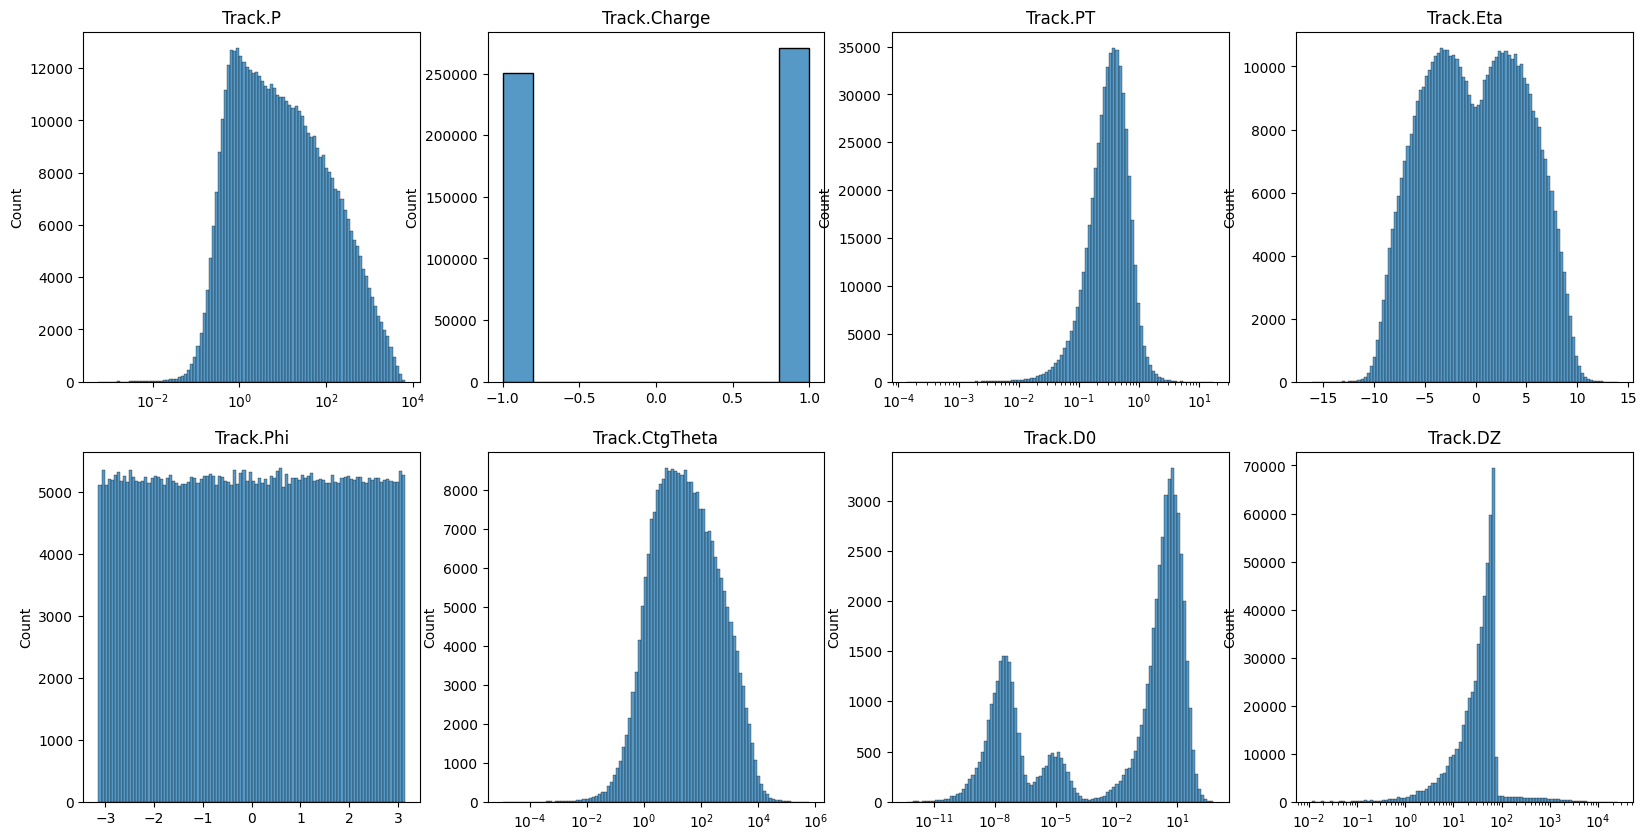

In [18]:
track_values_p = np.concatenate(data["Track"]["Track.P"].array()[:10000]).to_numpy()
track_values_charge = np.concatenate(data["Track"]["Track.Charge"].array()[:10000]).to_numpy()
track_values_pt = np.concatenate(data["Track"]["Track.PT"].array()[:10000]).to_numpy()
track_values_eta = np.concatenate(data["Track"]["Track.Eta"].array()[:10000]).to_numpy()
track_values_phi = np.concatenate(data["Track"]["Track.Phi"].array()[:10000]).to_numpy()
track_values_ctgtheta = np.concatenate(data["Track"]["Track.CtgTheta"].array()[:10000]).to_numpy()
track_values_d0 = np.concatenate(data["Track"]["Track.D0"].array()[:10000]).to_numpy()
track_values_dz = np.concatenate(data["Track"]["Track.DZ"].array()[:10000]).to_numpy()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
# Add title to plot
sns.histplot(track_values_p, ax=axs[0, 0], bins=100, log_scale=True)
axs[0, 0].set_title("Track.P")
sns.histplot(track_values_charge, ax=axs[0, 1], bins=10)
axs[0, 1].set_title("Track.Charge")
sns.histplot(track_values_pt, ax=axs[0, 2], bins=100, log_scale=True)
axs[0, 2].set_title("Track.PT")
sns.histplot(track_values_eta, ax=axs[0, 3], bins=100)
axs[0, 3].set_title("Track.Eta")
sns.histplot(track_values_phi, ax=axs[1, 0], bins=100)
axs[1, 0].set_title("Track.Phi")
sns.histplot(track_values_ctgtheta, ax=axs[1, 1], bins=100, log_scale=True)
axs[1, 1].set_title("Track.CtgTheta")
sns.histplot(np.abs(track_values_d0), ax=axs[1, 2], bins=100, log_scale=True)
axs[1, 2].set_title("Track.D0")
sns.histplot(np.abs(track_values_dz), ax=axs[1, 3], bins=100, log_scale=True)
axs[1, 3].set_title("Track.DZ")
plt.show()


## Hit-level Data

In [19]:
for key in data["Hits"].keys():
    print(key)
    try:
        track_values = data["Hits"][key].array()
        print("Values", track_values)
        print("Length", len(track_values))
    except:
        print("Values", "Not able to be loaded")

Hits.fUniqueID
Values [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Length 100000
Hits.fBits
Values [[50331648, 50331648, 50331648, 50331648, ... 50331648, 50331648, 50331648]]
Length 100000
Hits.r
Values [[0.0334, 0.0505, 0.0885, 0.123, 0.299, ... 0.275, 0.323, 0.386, 0.416, 0.528]]
Length 100000
Hits.z
Values [[-0.0285, -0.0134, 0.0205, 0.0511, 0.221, 0.302, ... 0.934, 1.09, 1.3, 1.4, 1.77]]
Length 100000
Hits.phi
Values [[-2.18, -2.15, -2.08, -2.02, -1.67, ... -0.178, -0.161, -0.14, -0.13, -0.0912]]
Length 100000
Hits.partIdx
Values [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ... 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57]]
Length 100000
Hits.vxTruth
Values [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Length 100000


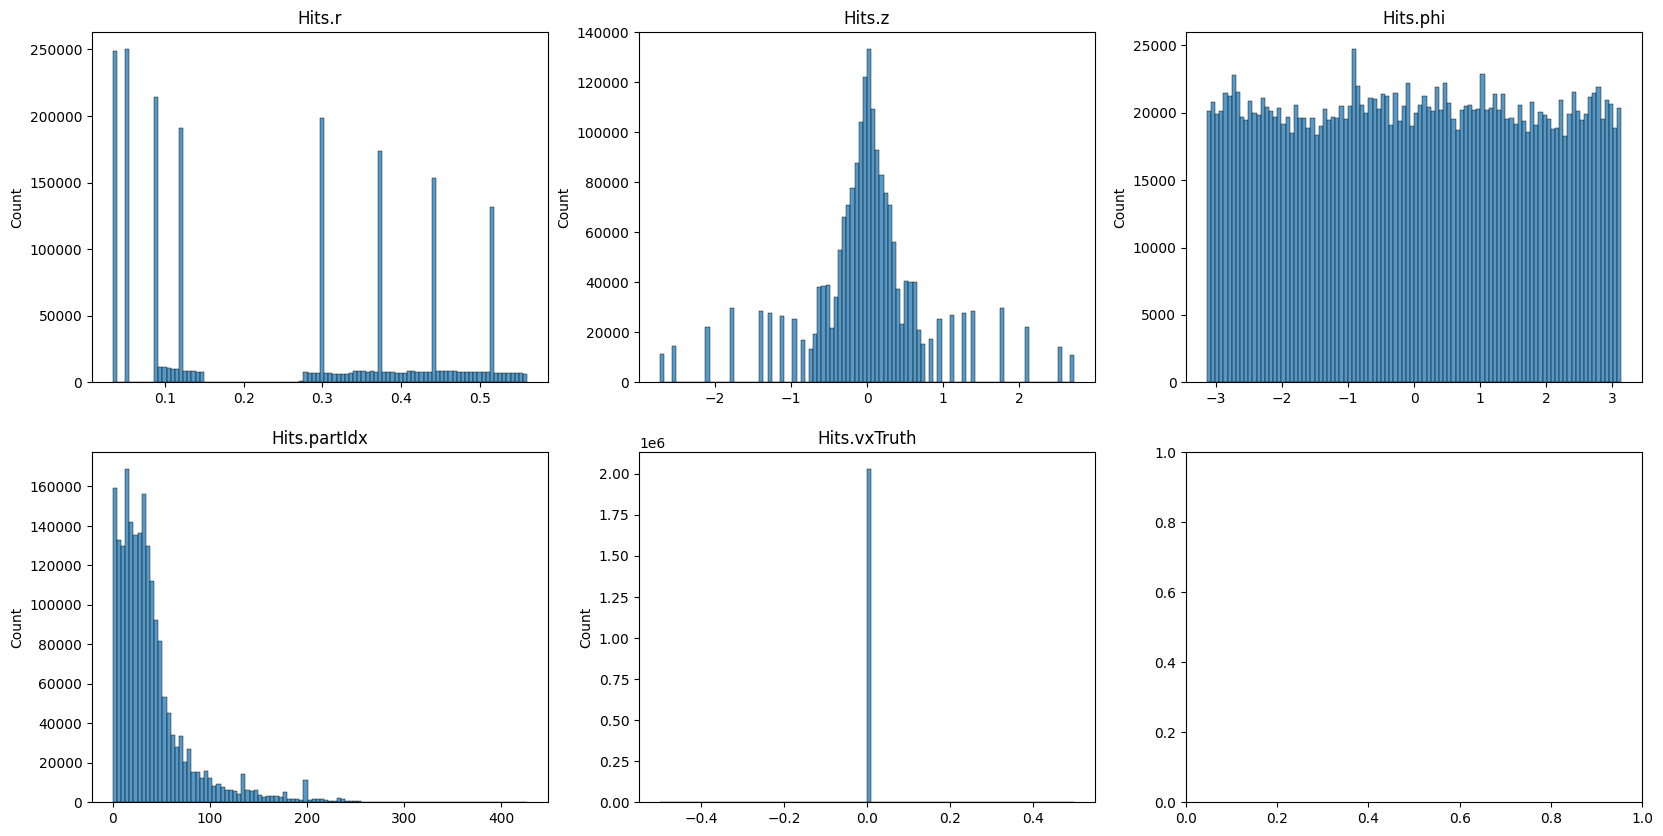

In [20]:
hit_values_r = np.concatenate(data["Hits"]["Hits.r"].array()[:10000]).to_numpy()
hit_values_z = np.concatenate(data["Hits"]["Hits.z"].array()[:10000]).to_numpy()
hit_values_phi = np.concatenate(data["Hits"]["Hits.phi"].array()[:10000]).to_numpy()
hit_values_partIdx = np.concatenate(data["Hits"]["Hits.partIdx"].array()[:10000]).to_numpy()
hit_values_vxTruth = np.concatenate(data["Hits"]["Hits.vxTruth"].array()[:10000]).to_numpy()

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
# Add title to plot
sns.histplot(hit_values_r, ax=axs[0, 0], bins=100)
axs[0, 0].set_title("Hits.r")
sns.histplot(hit_values_z, ax=axs[0, 1], bins=100)
axs[0, 1].set_title("Hits.z")
sns.histplot(hit_values_phi, ax=axs[0, 2], bins=100)
axs[0, 2].set_title("Hits.phi")
sns.histplot(hit_values_partIdx, ax=axs[1, 0], bins=100)
axs[1, 0].set_title("Hits.partIdx")
sns.histplot(hit_values_vxTruth, ax=axs[1, 1], bins=100)
axs[1, 1].set_title("Hits.vxTruth")
plt.show()

In [3]:
def plot_event(data, idx):
    if not isinstance(idx, list):
        idx = [idx]
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 10), dpi=100)
    for j,idx in enumerate(idx):
        sample_event_particle_id = data["Hits"]["Hits.partIdx"].array()[idx]
        sample_event_z = data["Hits"]["Hits.z"].array()[idx]
        sample_event_r = data["Hits"]["Hits.r"].array()[idx]
        sample_event_phi = data["Hits"]["Hits.phi"].array()[idx]
        sample_event_x = (sample_event_r * np.cos(sample_event_phi))
        sample_event_y = (sample_event_r * np.sin(sample_event_phi))

        # displaced_vert_x = data['DisplacedVertices/DisplacedVertices.X'].array()[idx]
        # displaced_vert_y = data['DisplacedVertices/DisplacedVertices.Y'].array()[idx]
        # displaced_vert_z = data['DisplacedVertices/DisplacedVertices.Z'].array()[idx]
        # displaced_vert_r = np.sqrt(displaced_vert_x**2 + displaced_vert_y**2)

        # reg_vert_x = data['Vertex/Vertex.X'].array()[idx]
        # reg_vert_y = data['Vertex/Vertex.Y'].array()[idx]
        # reg_vert_z = data['Vertex/Vertex.Z'].array()[idx]
        # reg_vert_r = np.sqrt(reg_vert_x**2 + reg_vert_y**2)

        # Define a list of markers
        markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']
        unique_particle_ids = sorted(np.unique(sample_event_particle_id))
        # Define a list of colors
        cmap = plt.get_cmap('Spectral')(np.linspace(0, 1, len(unique_particle_ids)))
        for i, particle_id in enumerate(unique_particle_ids):
            particle_id_mask = sample_event_particle_id == particle_id
            marker = markers[i % len(markers)]  # Cycle through markers if there are more particle IDs than markers
            axs[0].scatter(sample_event_x[particle_id_mask], sample_event_y[particle_id_mask], marker=marker, color=cmap[i], s=20)
            axs[1].scatter(sample_event_z[particle_id_mask], sample_event_x[particle_id_mask], marker=marker, color=cmap[i], s=20)
            axs[2].scatter(sample_event_z[particle_id_mask], sample_event_r[particle_id_mask], marker=marker, color=cmap[i], s=20)    

        # axs[0].scatter(displaced_vert_x, displaced_vert_y, marker='*', color='yellow', s=100, label='[QCD] Displaced Vertex', edgecolors='black', linewidths=1, zorder=np.inf)
        # axs[1].scatter(displaced_vert_z, displaced_vert_x, marker='*', color='yellow', s=100, label='[QCD] Displaced Vertex', edgecolors='black', linewidths=1, zorder=np.inf)
        # axs[2].scatter(displaced_vert_z, displaced_vert_r, marker='*', color='yellow', s=100, label='[QCD] Displaced Vertex', edgecolors='black', linewidths=1, zorder=np.inf)

        # axs[0].scatter(reg_vert_x, reg_vert_y, marker='o', color='red', s=75, label='[QCD] Reg. Vertex', edgecolors='darkred', linewidths=3)
        # axs[1].scatter(reg_vert_z, reg_vert_x, marker='o', color='red', s=75, label='[QCD] Reg. Vertex', edgecolors='darkred', linewidths=3)
        # axs[2].scatter(reg_vert_z, reg_vert_r, marker='o', color='red', s=75, label='[QCD] Reg. Vertex', edgecolors='darkred', linewidths=3)

    axs[0].legend(frameon=False, loc='upper right', fontsize=14, prop=dict(weight='bold'))
    axs[1].legend(frameon=False, loc='upper right', fontsize=14, prop=dict(weight='bold'))
    axs[2].legend(frameon=False, loc='upper right', fontsize=14, prop=dict(weight='bold'))

    axs[0].set_title("Down beampipe view")
    axs[1].set_title("Side view")
    axs[2].set_title("Angular view")
    axs[0].axvline(x=0, color='grey', linestyle='--', zorder=-np.inf, linewidth=0.5)
    axs[0].axhline(y=0, color='grey', linestyle='--', zorder=-np.inf, linewidth=0.5)
    axs[1].axvline(x=0, color='grey', linestyle='--', zorder=-np.inf, linewidth=0.5)
    axs[2].axvline(x=0, color='grey', linestyle='--', zorder=-np.inf, linewidth=0.5)
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    axs[1].set_xlabel('z')
    axs[1].set_ylabel('x')
    axs[2].set_xlabel('z')
    axs[2].set_ylabel('r')
    plt.show()


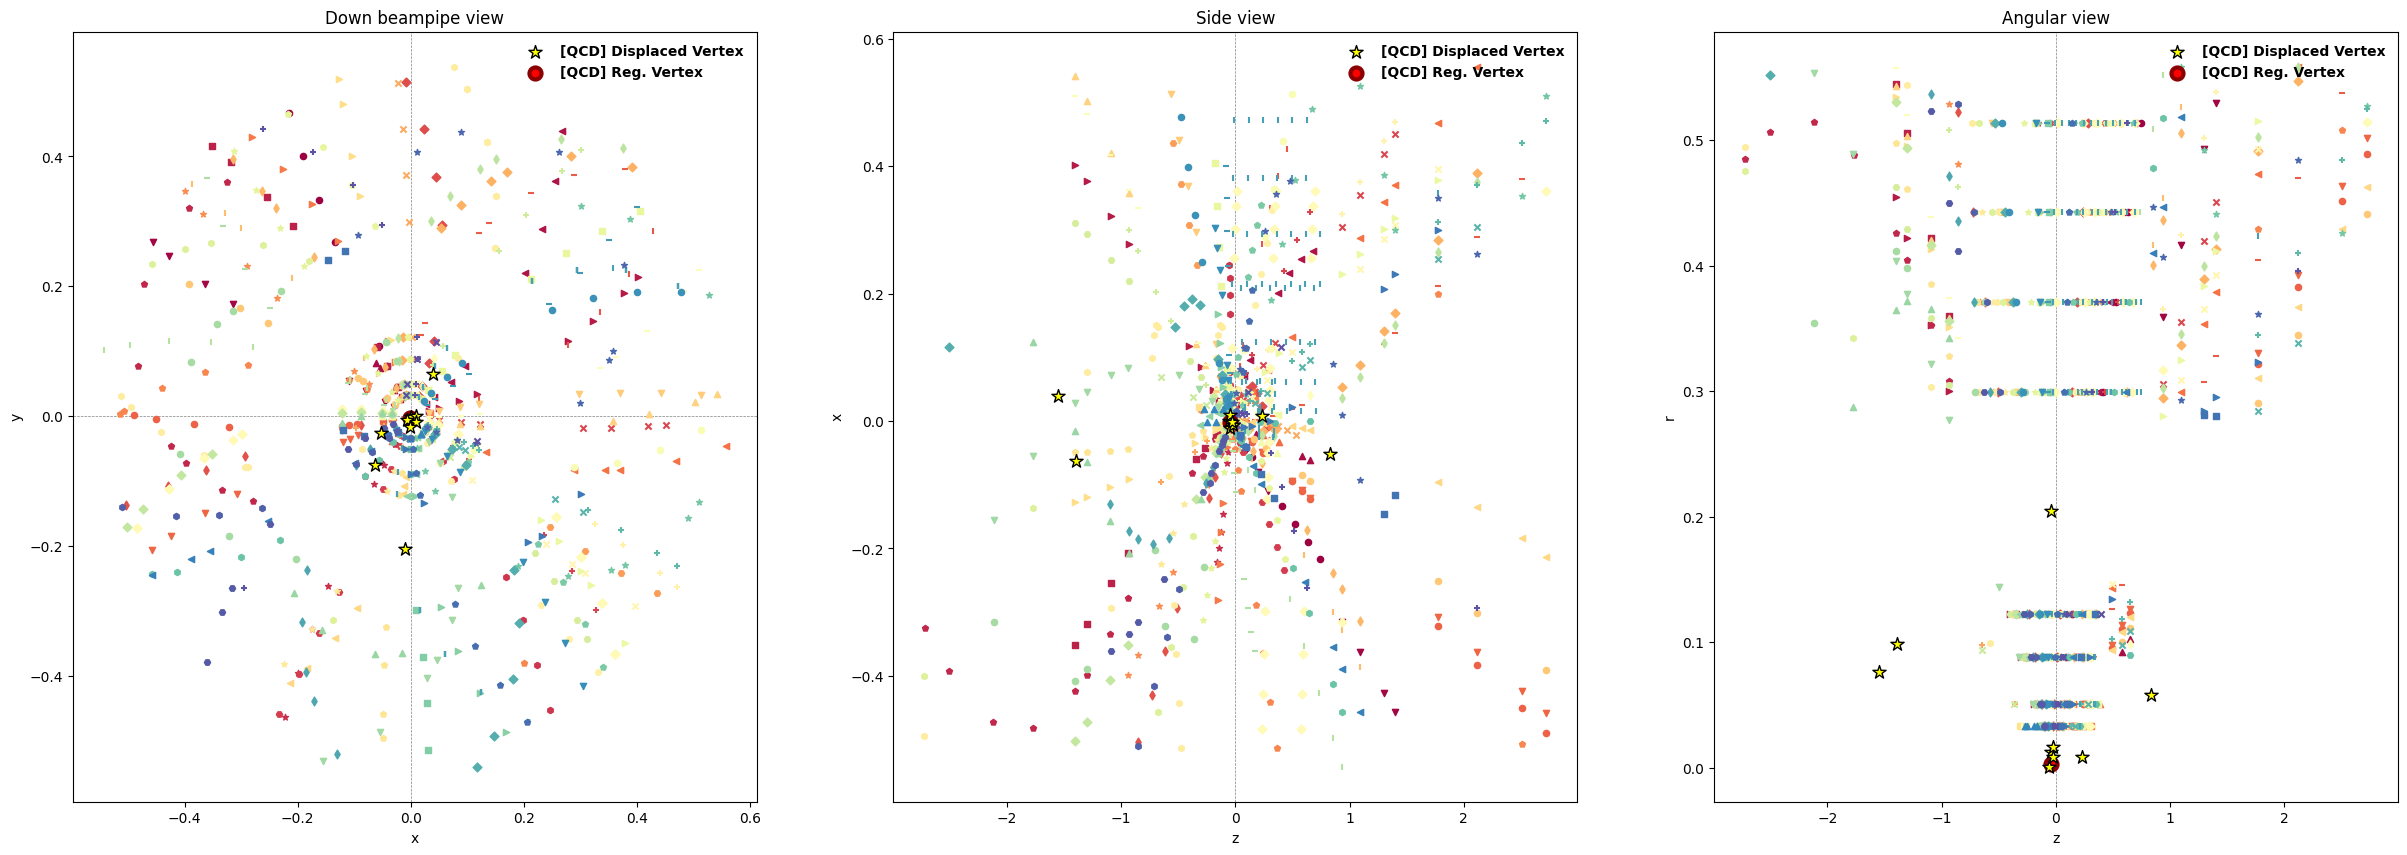

In [26]:
plot_event(data, 1)

In [2]:
import awkward as ak

base = "~/data/atlas/qcd_llp_datasets/"
qcd = base + "QCD_multijet_events_200k.root"
llp = [base + "500GeV_n3_events_100k.root", base + "100GeV_n3_events_100k.root"]

data_llp_100 = uproot.open(llp[1])["Delphes"]
data_llp_500 = uproot.open(llp[0])["Delphes"]
data_qcd = uproot.open(qcd)["Delphes"]

data_llp_100mm = uproot.open('/sdf/home/y/youngsam/data/atlas/MadGraphRuns/neutralLLP_MS_1_4/Events/run_06_decayed_1/1000_LLP_events_100mm.root')['Delphes']

In [21]:
PT_100 = data_llp_100['Track/Track.PT'].array(entry_stop=1000)
PT_500 = data_llp_500['Track/Track.PT'].array(entry_stop=1000)
QCD_PT = data_qcd['Track/Track.PT'].array(entry_stop=1000)
PT_100mm = data_llp_100mm['Track/Track.PT'].array(entry_stop=1000)

In [28]:
num_highest_tracks = 5

PT_100 = PT_100 / ak.sum(PT_100, axis=1)
PT_500 = PT_500 / ak.sum(PT_500, axis=1)
QCD_PT = QCD_PT / ak.sum(QCD_PT, axis=1)
PT_100mm = PT_100mm / ak.sum(PT_100mm, axis=1)

PT_100 = PT_100[ak.argsort(PT_100,axis=1)]#[:,-num_highest_tracks:]
PT_500 = PT_500[ak.argsort(PT_500,axis=1)]#[:,-num_highest_tracks:]
QCD_PT = QCD_PT[ak.argsort(QCD_PT,axis=1)]#[:,-num_highest_tracks:]
PT_100mm = PT_100mm[ak.argsort(PT_100mm,axis=1)]#[:,-num_highest_tracks:]

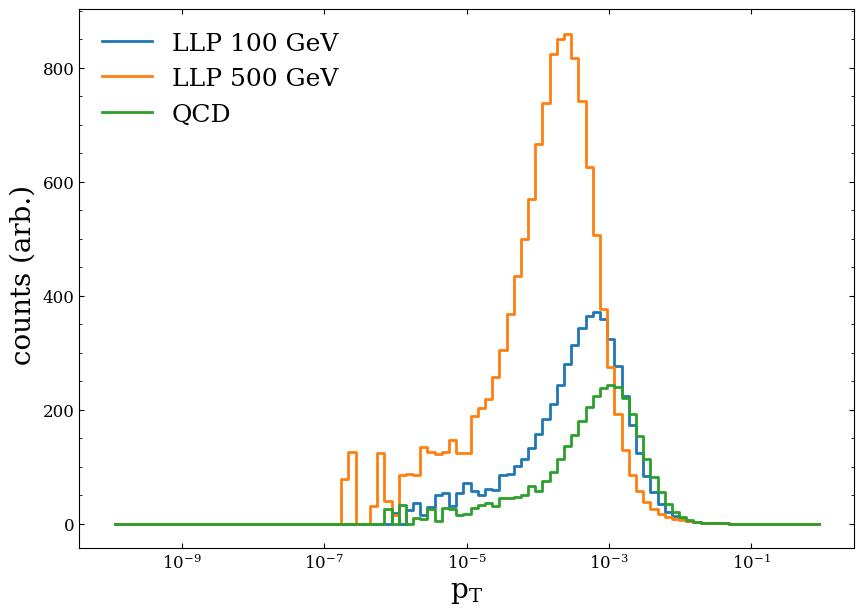

In [37]:
def get_hist(data, bins):
    c,e = np.histogram(data.to_numpy(), bins=bins)
    c = c.astype(float)
    centers = (e[:-1] + e[1:]) / 2
    c = c / (np.sum(c) * (e[1:] - e[:-1]))
    return centers, c

bins = np.logspace(-10,0,100)
plt.plot(*get_hist((ak.ravel(PT_100)), bins), label="LLP 100 GeV", drawstyle='steps-mid', lw=2);
plt.plot(*get_hist((ak.ravel(PT_500)), bins), label="LLP 500 GeV", drawstyle='steps-mid', lw=2);
plt.plot(*get_hist((ak.ravel(QCD_PT)), bins), label="QCD", drawstyle='steps-mid', lw=2);
plt.legend(frameon=False, fontsize=18)
plt.xlabel("$p_T$", fontsize=20)
# plt.ylim(0,)
plt.xscale('log')
# plt.yscale('log')
plt.ylabel(' counts (arb.)', fontsize=20)
plt.show()

In [23]:
a = data_qcd['Track']['Track.PT'].array(entry_stop=100)
a = a / ak.sum(a,axis=1)

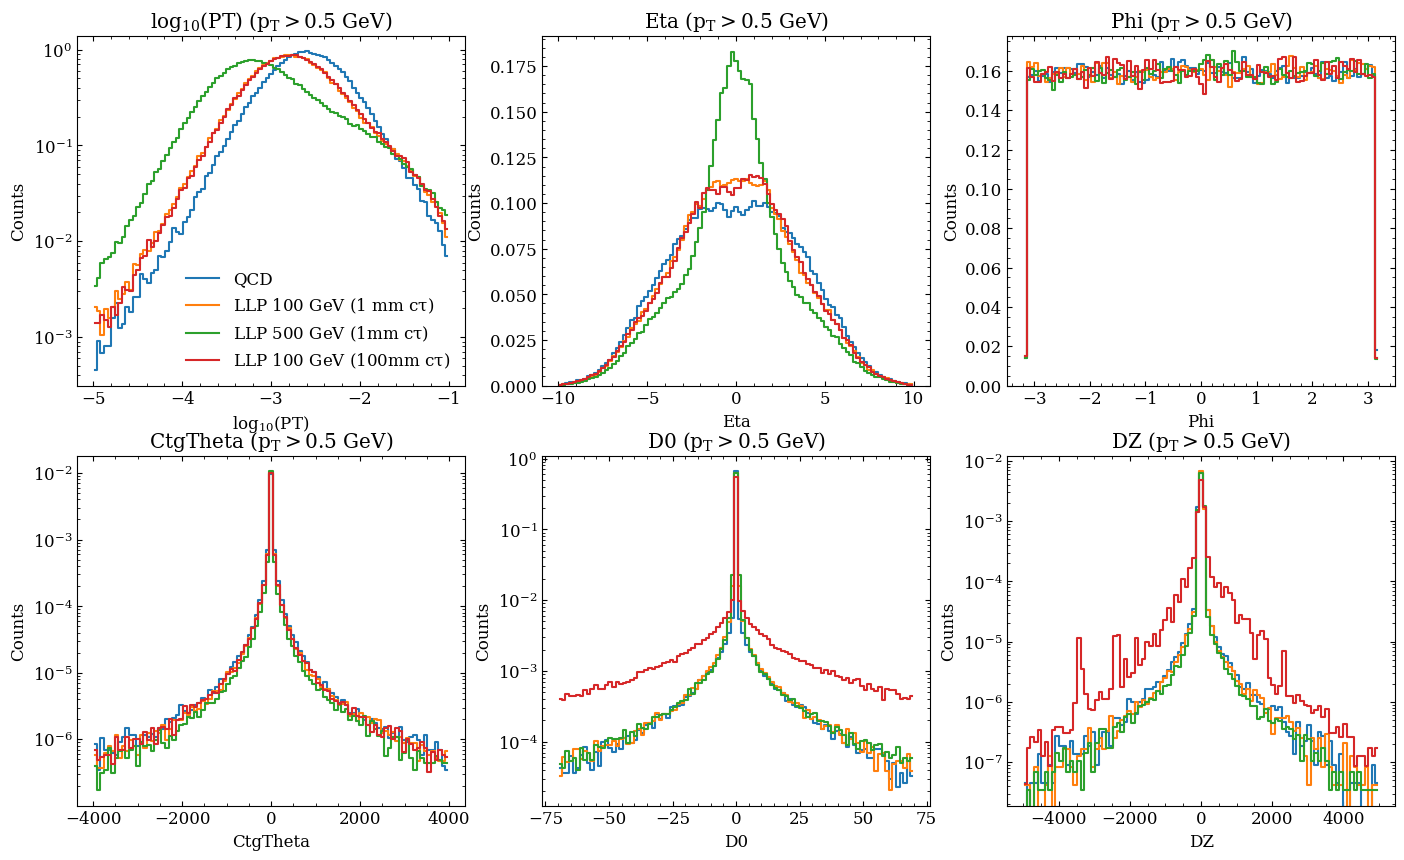

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))
for data, dset_label in zip(
    [data_qcd, data_llp_100, data_llp_500, data_llp_100mm],
    ["QCD", "LLP 100 GeV (1 mm $c\\tau$)", "LLP 500 GeV (1mm $c\\tau$)", "LLP 100 GeV (100mm $c\\tau$)"],
):
    # Add title to plot
    labels = ["PT", "Eta", "Phi", "CtgTheta", "D0", "DZ"]
    log_scales = [True, False, False, True, True, True]

    # ptcut = data["Track"]["Track.PT"].array(entry_stop=1000) > 0.5

    for label, ax, log_scale in zip(labels, axs.ravel(), log_scales):
        for tree in ["Track"]:
            vals = data[tree][f"{tree}.{label}"].array(entry_stop=1000)

            if label == "PT":
                vals = vals / ak.sum(vals, axis=1)
                vals = np.log10(vals)
            vals = np.concatenate(vals).to_numpy()
            bins ={
                'PT': (-5,-1),
                'Eta': (-10,10),
                'Phi': (-3.2,3.2),
                'CtgTheta': (-4000,4000),
                'D0': (-70,70),
                'DZ': (-5000,5000)
            }
            bins = np.linspace(*bins[label], 100)
            
            counts,edges = np.histogram(vals, bins=bins)
            centers = (edges[:-1] + edges[1:]) / 2            
            counts = counts.astype(float) / (np.sum(counts) * (edges[1] - edges[0]))
            ax.plot(centers, counts, label=dset_label, drawstyle='steps-mid')

            if dset_label=='LLP 500 GeV (1mm $c\\tau$)':
                if log_scale:
                    ax.set_yscale("log")
                    ax.set_ylim(None, None) 
                else:
                    ax.set_ylim(0,)

        ax.set_ylabel("Counts")
        
        if label == "PT":
            ax.legend(frameon=False, fontsize=12)
            
        if label == 'PT':
            label = '$log_{10}$(PT)'
        
        ax.set_xlabel(label)
        ax.set_title(label + ' ($p_T>0.5$ GeV)')
        
    # ax.set_xlim(None,max(vals))ls
plt.show()

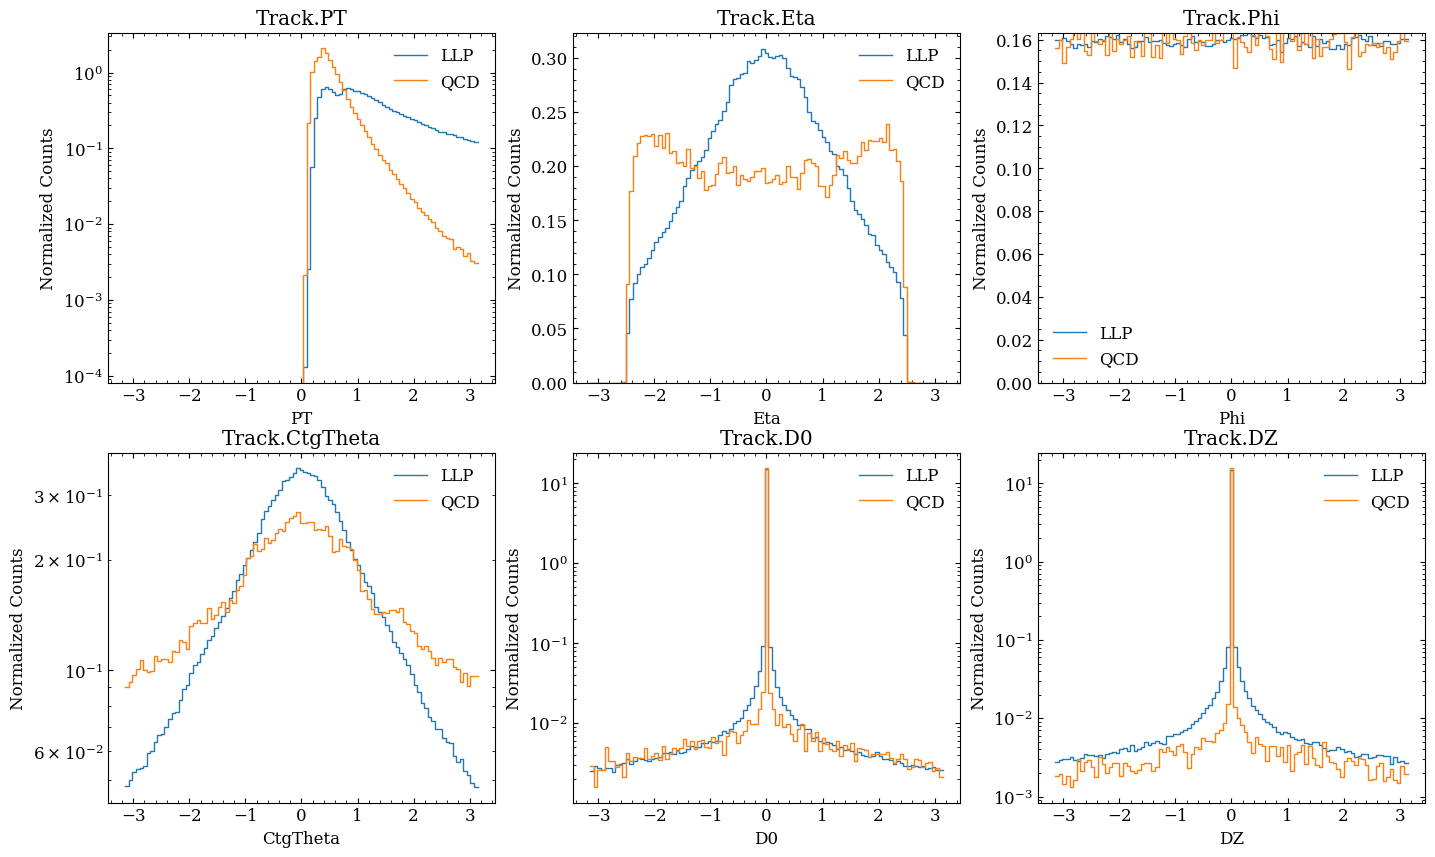

In [54]:
fig, axs = plt.subplots(2, 3, figsize=(17, 10))

for data,dset_label in zip([data_llp, data_qcd], ['LLP', 'QCD']):
    track_values_pt = np.concatenate(data["Track"]["Track.PT"].array()[:]).to_numpy()
    track_values_eta = np.concatenate(data["Track"]["Track.Eta"].array()[:]).to_numpy()
    track_values_phi = np.concatenate(data["Track"]["Track.Phi"].array()[:]).to_numpy()
    track_values_ctgtheta = np.concatenate(data["Track"]["Track.CtgTheta"].array()[:]).to_numpy()
    track_values_d0 = np.concatenate(data["Track"]["Track.D0"].array()[:]).to_numpy()
    track_values_dz = np.concatenate(data["Track"]["Track.DZ"].array()[:]).to_numpy()

    # Add title to plot
    labels = ['PT', 'Eta', 'Phi', 'CtgTheta', 'D0', 'DZ']
    log_scales = [True, False, False, True, True, True]
    for label,ax,log_scale in zip(labels, axs.ravel(), log_scales):
        vals = np.concatenate(data["Track"][f"Track.{label}"].array()[:]).to_numpy()
        sns.histplot(vals, ax=ax, bins=np.linspace(-np.pi,np.pi,100), label=dset_label, log_scale=False, element='step',
                     stat='density', fill=False, linewidth=1)
        if log_scale:
            ax.set_yscale('log')
        else:
            ax.set_ylim(0,)
        ax.set_ylabel('Normalized Counts')
        ax.set_xlabel(label)
        ax.set_title(f'Track.{label}')
        # ax.set_xlim(None,max(vals))
        ax.legend(frameon=False, fontsize=12)
plt.show()

___

## 2/26/2024

* Plot parameter distribution for a single event, like 50 tracks, to see if the distributions are easy to classify against

In [13]:
import awkward as ak

base = "~/data/atlas/qcd_llp_datasets/"
qcd = base + "QCD_multijet_events_200k.root"
llp = base + "100GeV_n3_events_100k_1mm.root"

data_llp = uproot.open(llp)["Delphes"]
data_qcd = uproot.open(qcd)["Delphes"]

In [6]:
# Plot parameter distribution for like 10 events individually
def plot_event(data, idx, title='', c='tab:blue', a=1):
    if not isinstance(idx, list):
        idx = [idx]
    
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=100)
    axs = axs.ravel()
    
    for idx in idx:
        sample_event_pt = data["Track"]["Track.PT"].array(entry_stop=20)[idx]
        pt_cut = sample_event_pt > 0.5
        sample_event_pt = sample_event_pt / np.sum(sample_event_pt)
        
        sample_event_pt = sample_event_pt[pt_cut]
        # argsort
        sorted_event_pt = np.argsort(sample_event_pt)
        sample_event_pt = sample_event_pt[sorted_event_pt][-50:]
        sample_event_eta = data["Track"]["Track.Eta"].array(entry_stop=20)[idx][pt_cut][sorted_event_pt][-50:]
        sample_event_phi = data["Track"]["Track.Phi"].array(entry_stop=20)[idx][pt_cut][sorted_event_pt][-50:]
        sample_event_d0 = data["Track"]["Track.D0"].array(entry_stop=20)[idx][pt_cut][sorted_event_pt][-50:]
        sample_event_dz = data["Track"]["Track.DZ"].array(entry_stop=20)[idx][pt_cut][sorted_event_pt][-50:]
        
        axs[0].hist(sample_event_pt, bins=np.linspace(0,0.6,20), log=False, histtype='step', label='PT', color=c,
                    alpha=a)
        axs[0].set_xlabel('$p_T$')
        axs[0].set_ylabel('Counts')
        
        
        axs[1].hist(np.log10(sample_event_pt), bins=np.linspace(-4,-0.5,20), log=False, histtype='step', label='log10(PT)', color=c,
                    alpha=a)
        axs[1].set_xlabel('$log_{10}(p_T)$')
        axs[2].hist(sample_event_eta, bins=np.linspace(-7,7,20), log=False, histtype='step', label='Eta', color=c,
                    alpha=a)
        axs[2].set_xlabel('$\\eta$')
        axs[3].hist(sample_event_phi, bins=np.linspace(-np.pi,np.pi,20), log=False, histtype='step', label='Phi', color=c,
                    alpha=a)
        axs[3].set_xlabel('$\\phi$')
        axs[4].hist(sample_event_d0, bins=np.linspace(-50,50,20), log=True, histtype='step', label='D0', color=c,
                    alpha=a)
        axs[4].set_xlabel('$d_0$')
        axs[5].hist(sample_event_dz, bins=np.linspace(-500,500,20), log=True, histtype='step', label='DZ', color=c,
                    alpha=a)
        axs[5].set_xlabel('$d_z$')

    # for ax in axs[:-1]:
    #     ax.legend()

    if title:
        plt.suptitle(title, y=0.9)

    plt.savefig('plots/'+title.lower().replace(' ', '_')+'.png', dpi=100)
    plt.show()

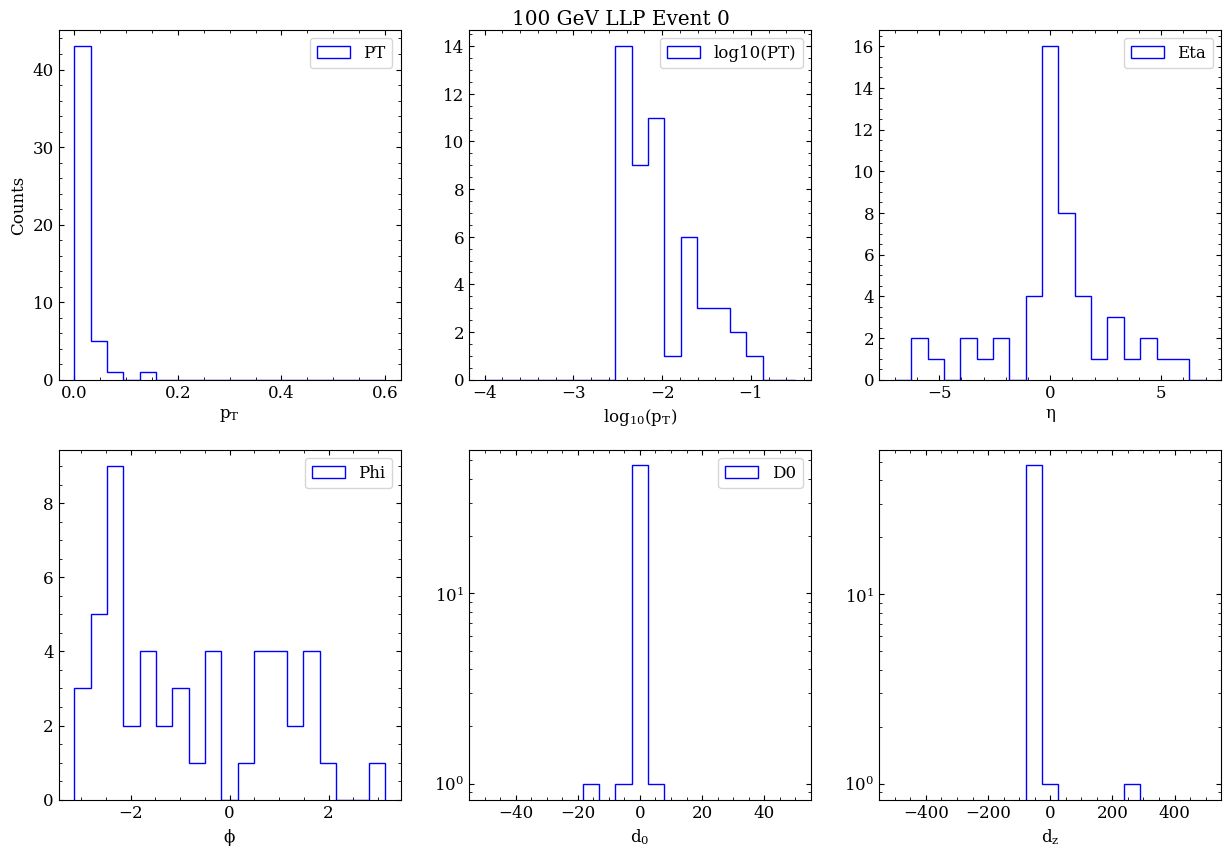

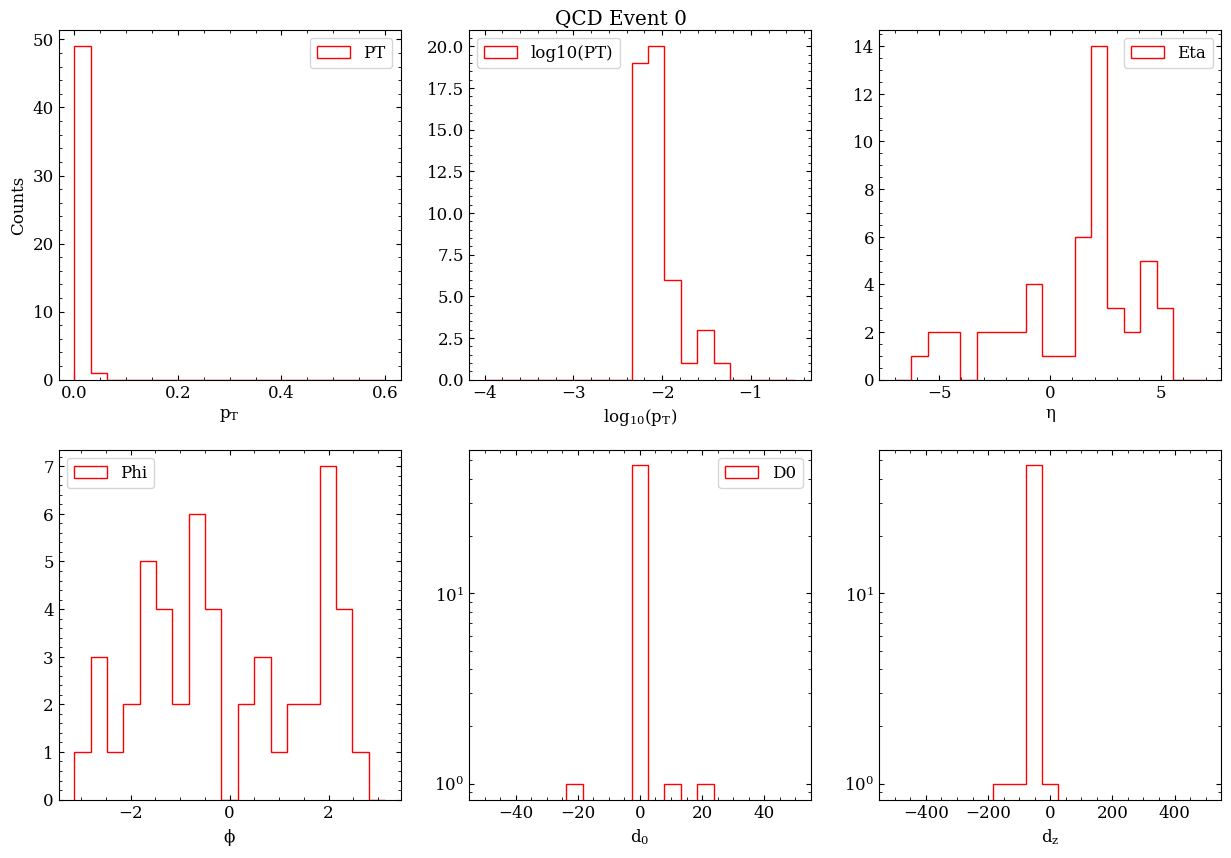

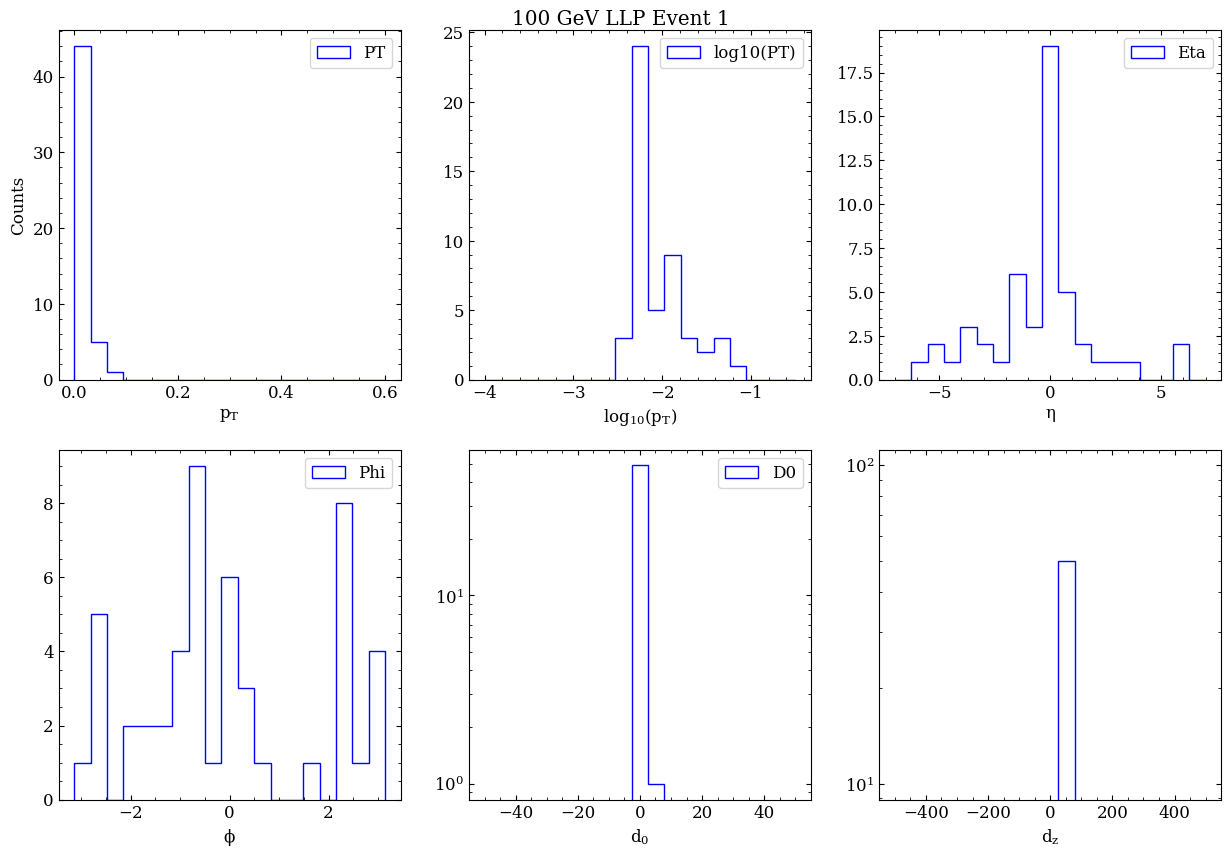

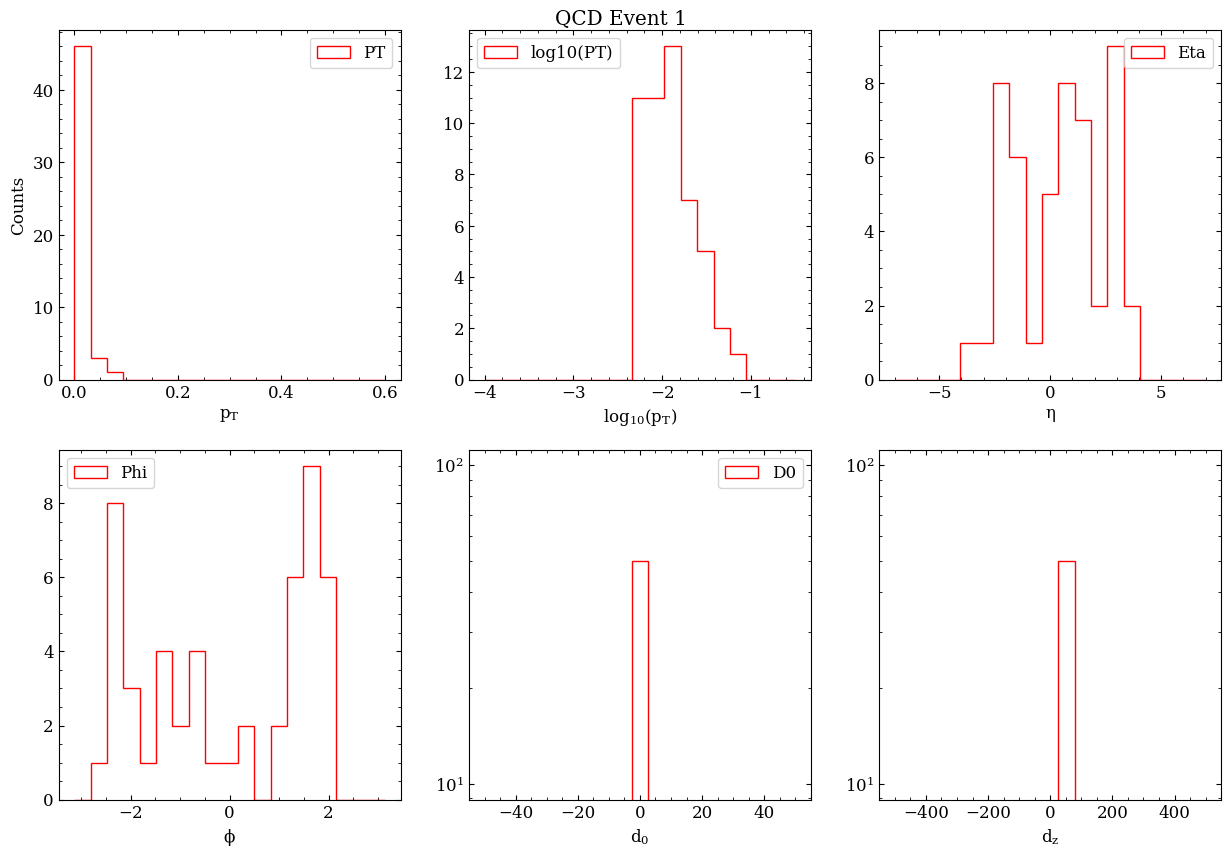

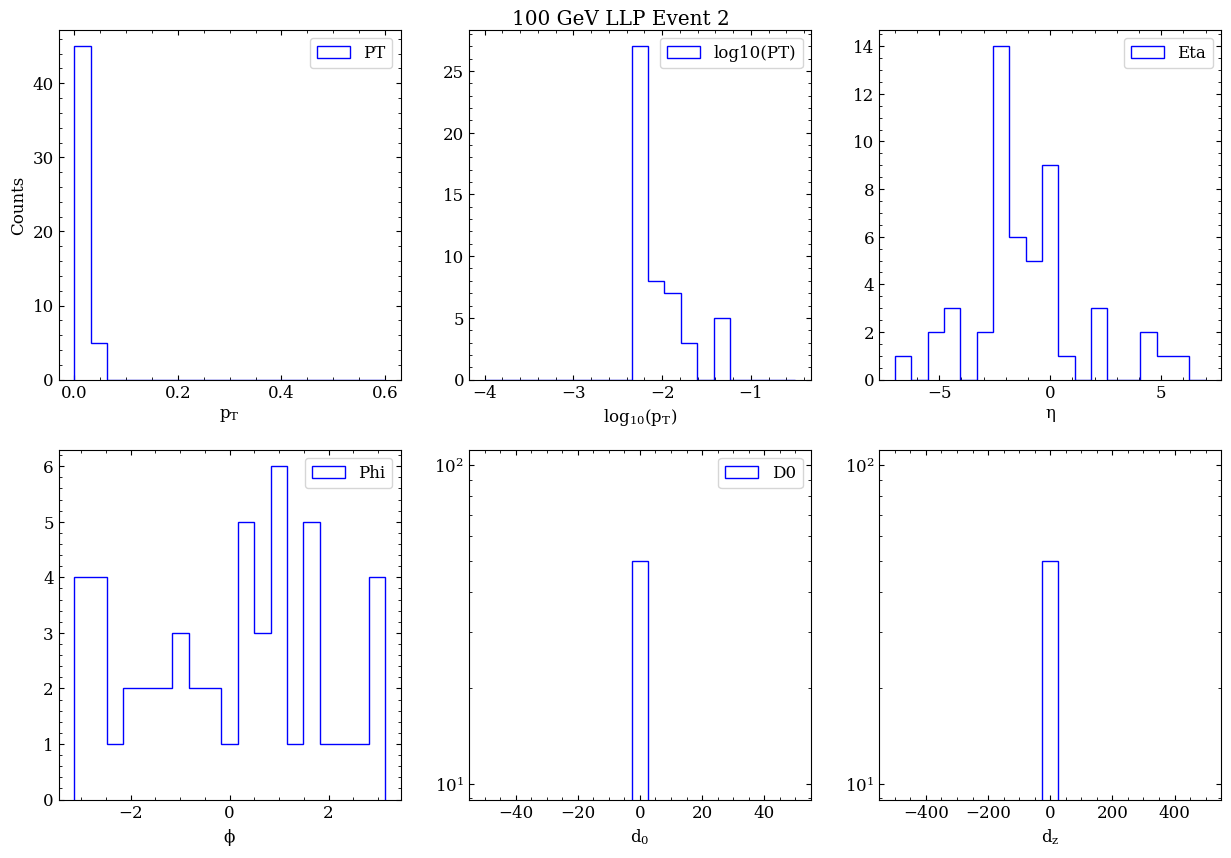

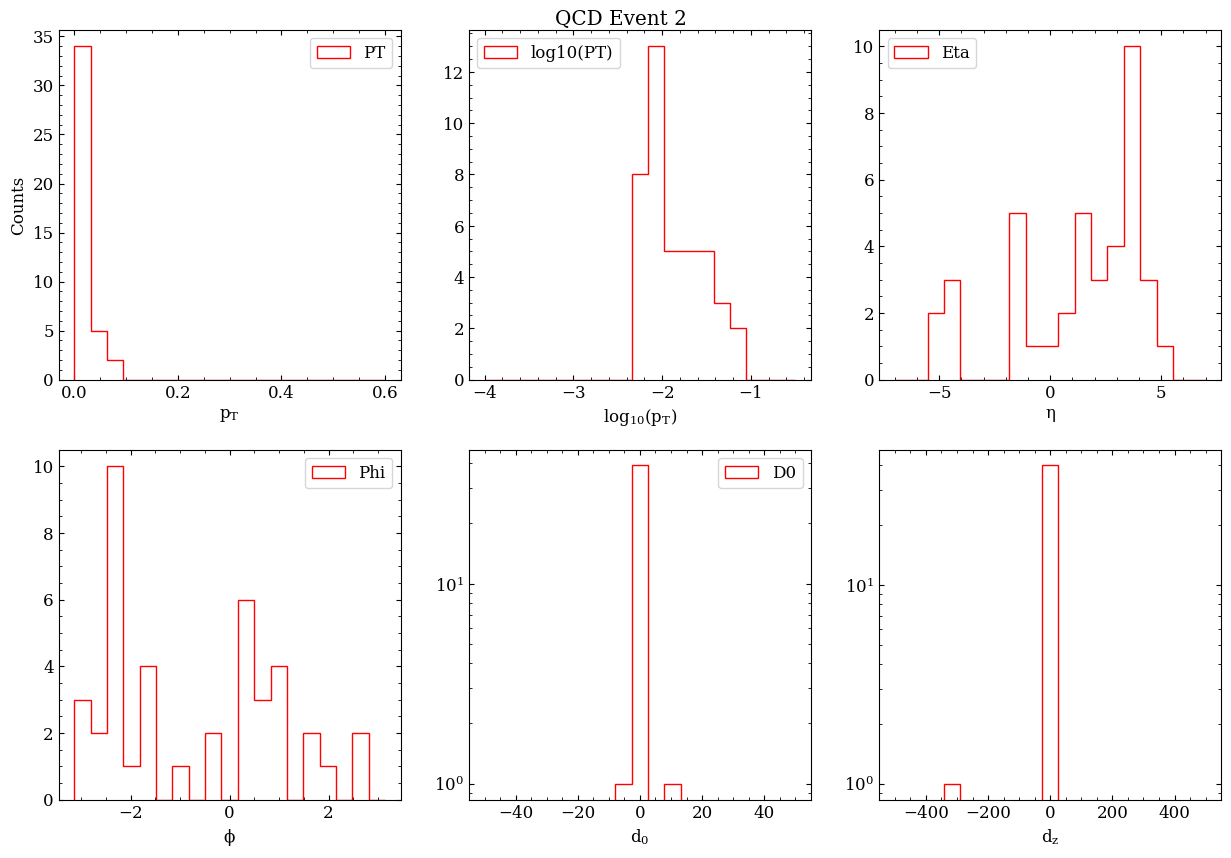

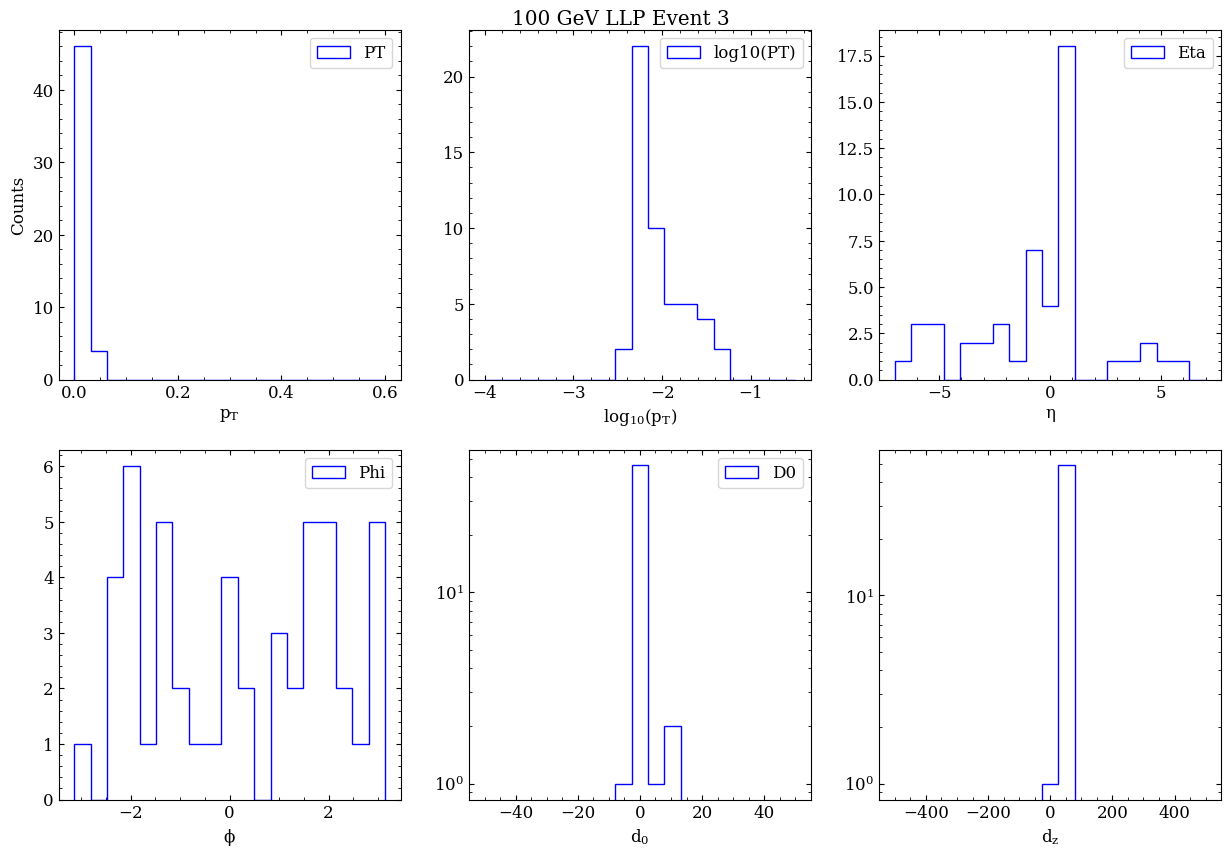

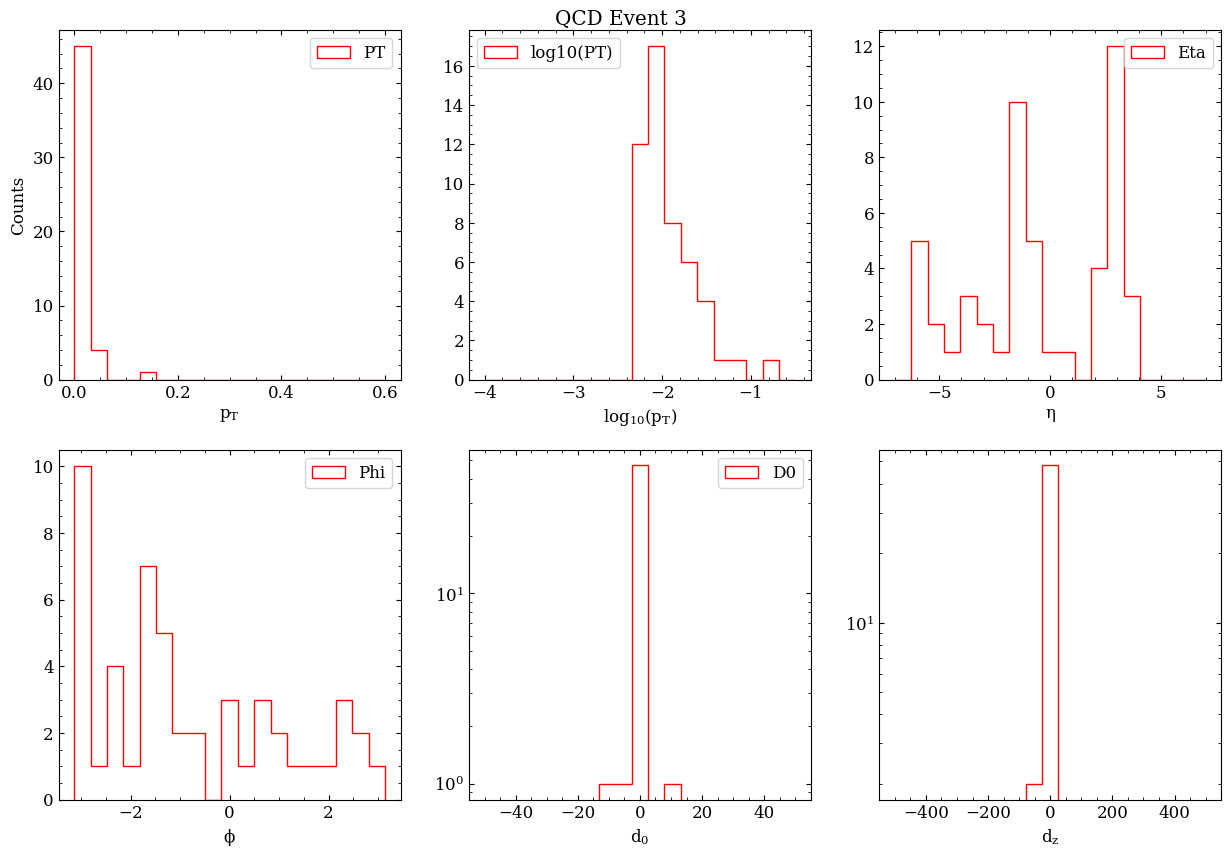

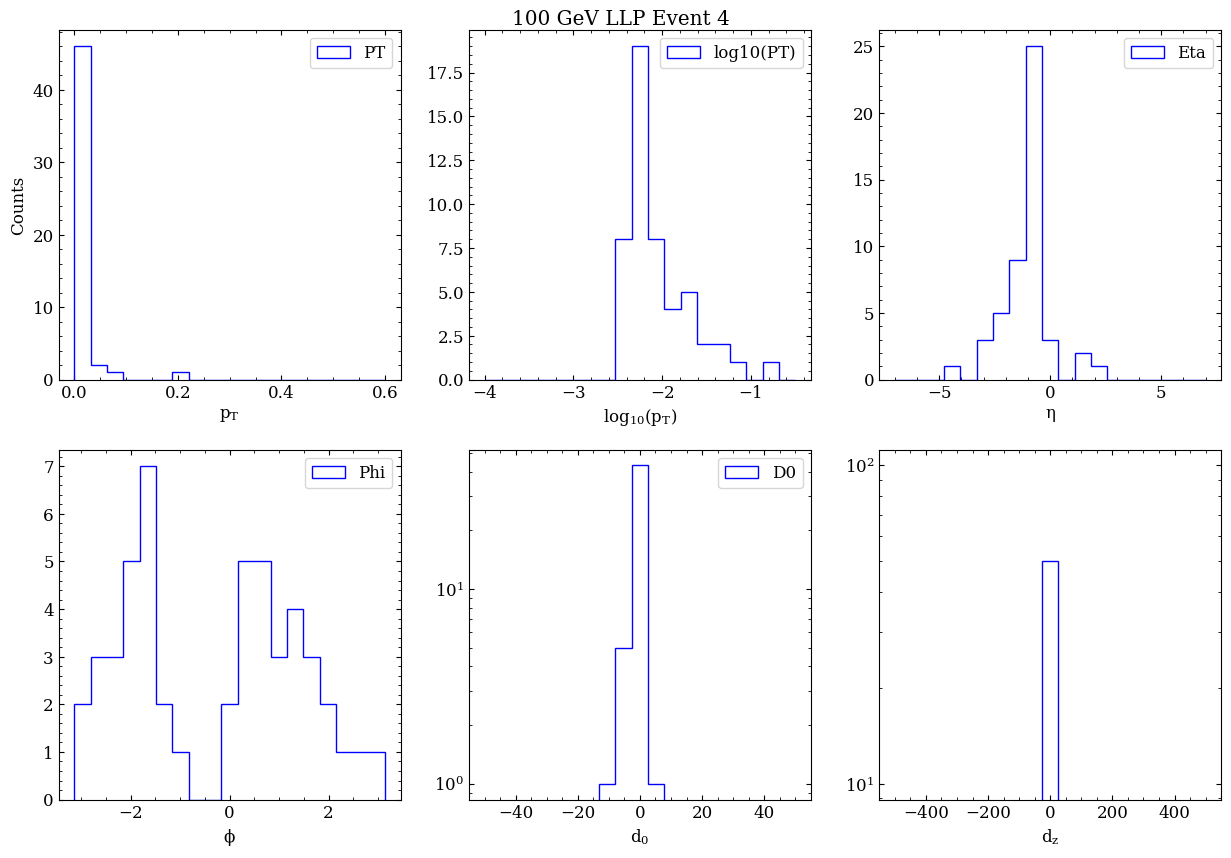

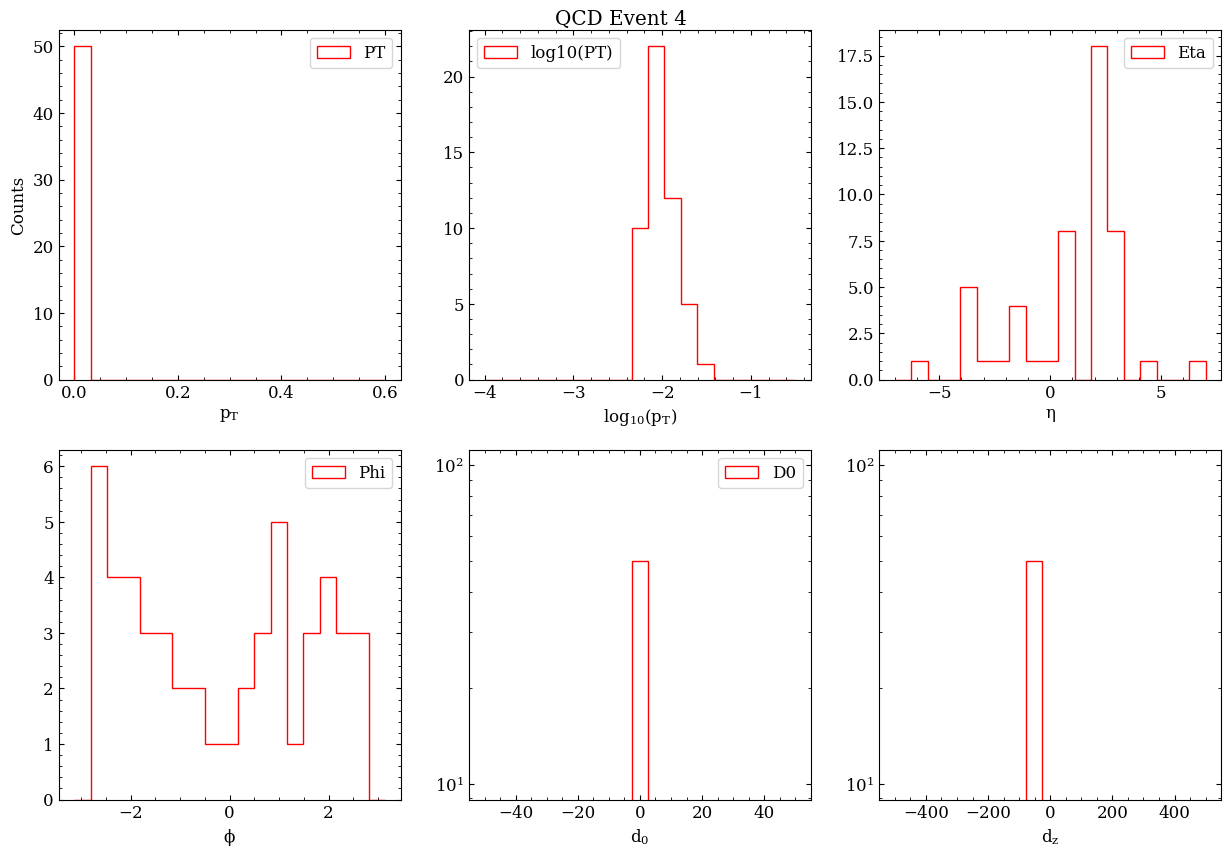

In [5]:
for i in range(5):
    plot_event(data_llp, i, title=f'100 GeV LLP Event {i}', c='blue')
    plot_event(data_qcd, i, title=f'QCD Event {i}', c='red')

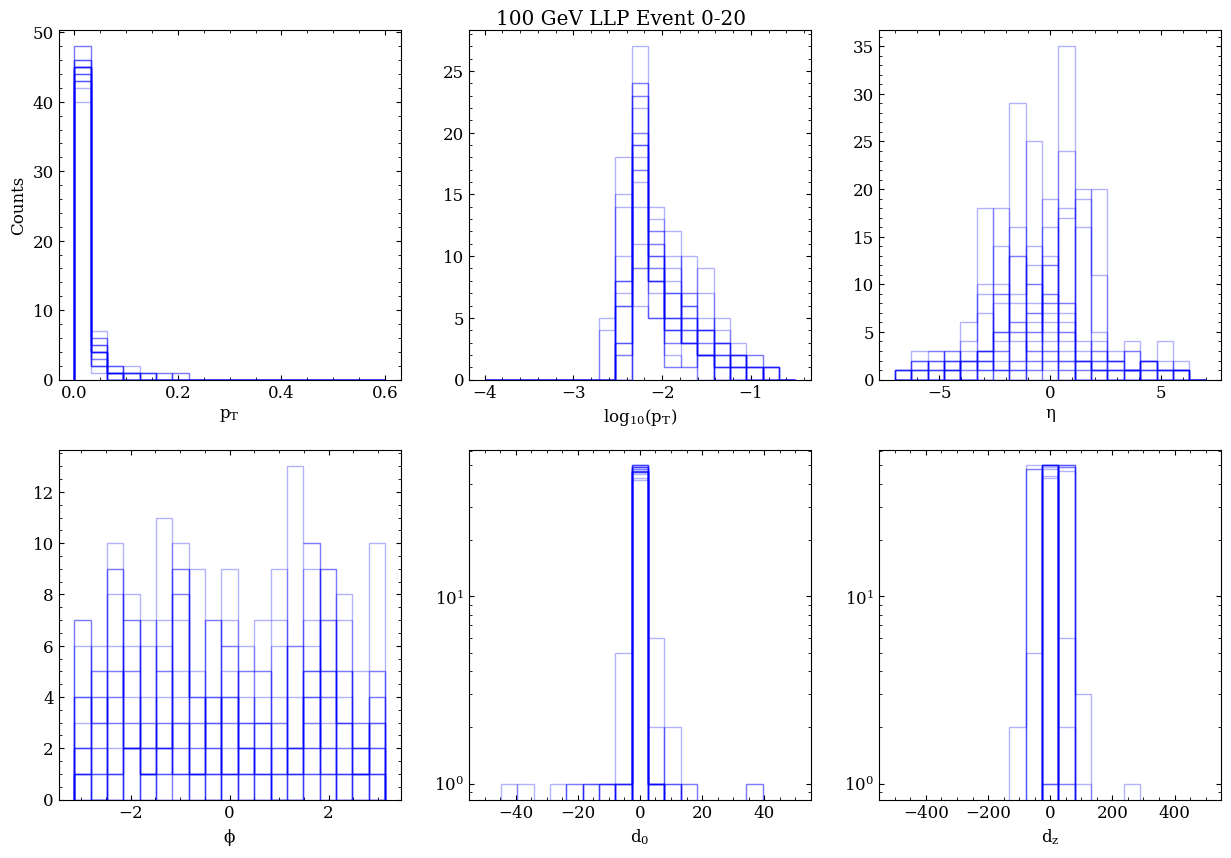

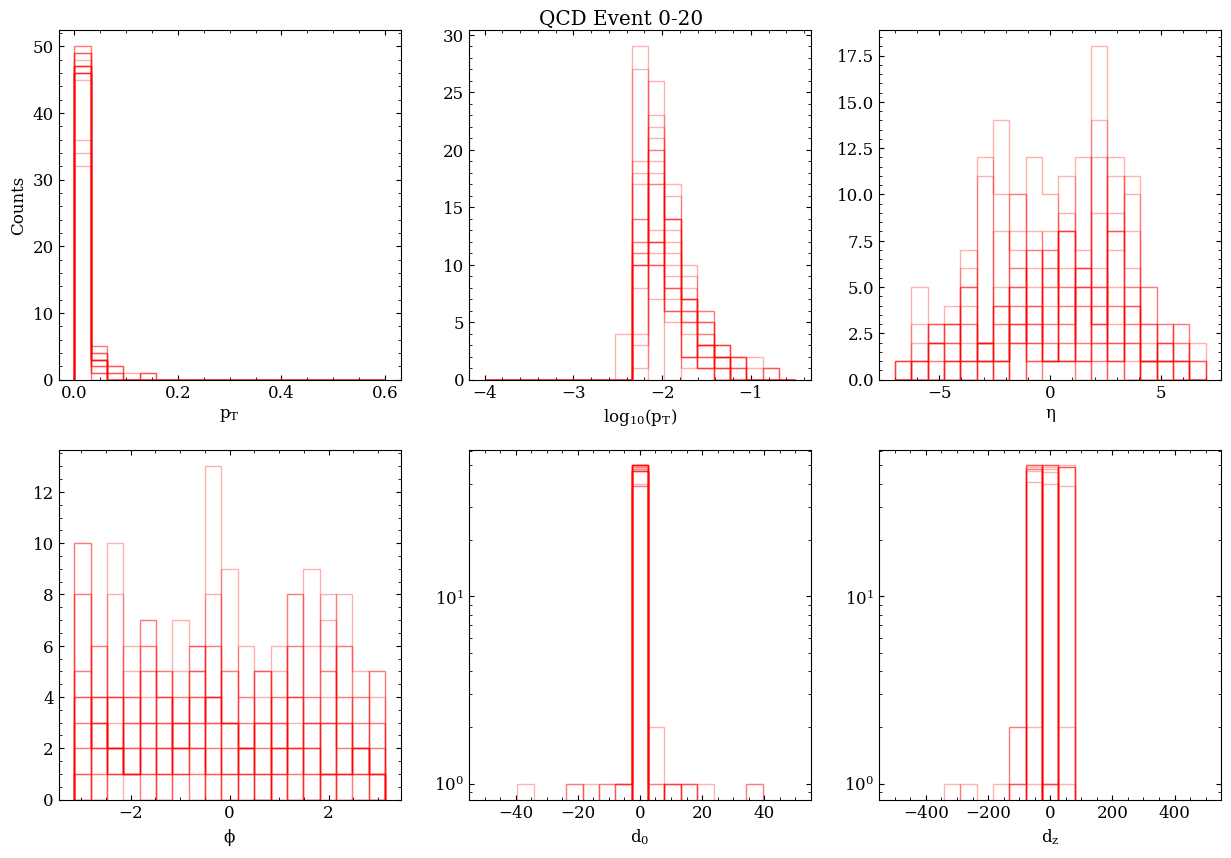

In [14]:
plot_event(data_llp, list(range(20)), title=f'100 GeV LLP Event 0-20', c='blue', a=0.3)
plot_event(data_qcd, list(range(20)), title=f'QCD Event 0-20', c='red', a=0.3)

For each signal dataset, plot out input parameters

In [54]:
from glob import glob
input_files = glob('/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/*.root')
input_files = [f for f in input_files if 'pileup' not in f]
qcd_file = '/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/QCD_multijet_events_200k.root'
input_files.remove(qcd_file)
input_files

['/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/500GeV_n3_events_100k_100mm.root',
 '/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/100GeV_n3_events_100k_100mm.root',
 '/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/500GeV_n3_events_100k_1mm.root',
 '/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/100GeV_n3_events_100k_1mm.root',
 '/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/Nc3Nf3_events_100k.root']

In [55]:
import os
import awkward as ak

def plot_input_parameters(input_file, qcd_file):
    data_input = uproot.open(input_file)["Delphes"]
    data_input_pileup = uproot.open(input_file.replace('.root', '_pileup.root'))["Delphes"]
    data_qcd = uproot.open(qcd_file)["Delphes"]
    data_qcd_pileup = uproot.open(qcd_file.replace('.root', '_pileup.root'))["Delphes"]
    
    title = os.path.basename(input_file).replace('.root', '').replace('_events', '')

    fig, axs = plt.subplots(2, 3, figsize=(17, 10))
    for data, dset_label in zip([data_qcd, data_qcd_pileup, data_input, data_input_pileup],['QCD', 'QCD + pileup', 'LLP', 'LLP + pileup']):
        # Add title to plot
        labels = ["PT", "PT", "Eta", "Phi", "D0", "DZ"]
        log_scales = [True, False, False, False, True, True]

        pt = data["Track"]["Track.PT"].array(entry_stop=50000)
        ptcut = pt > 0.5
        argsort = ak.argsort(pt[ptcut], axis=1) 

        for i, (label, ax, log_scale) in enumerate(zip(labels, axs.ravel(), log_scales)):
            vals = data["Track"][f"Track.{label}"].array(entry_stop=50000)[ptcut][argsort][:,-50:]

            if label == "PT":
                vals = vals / ak.sum(vals, axis=1)
            if i == 1:
                vals = np.log10(vals)
                label = 'log10(PT)'

            vals = np.concatenate(vals).to_numpy()
            bins = {
                'PT': (0, 0.6),
                'log10(PT)': (-3,-0.5),
                'Eta': (-10,10),
                'Phi': (-3.2,3.2),
                'CtgTheta': (-4000,4000),
                'D0': (-70,70),
                'DZ': (-2000,2000)
            }
            bins = np.linspace(*bins[label], 100)
            
            counts,edges = np.histogram(vals, bins=bins,density=True)
            centers = (edges[:-1] + edges[1:]) / 2            
            ax.plot(centers, counts, label='normalized PT' if dset_label == 'PT' else dset_label, drawstyle='steps-mid')

            if log_scale:
                ax.set_yscale("log")
                ax.set_ylim(None, None)

            ax.set_ylabel("Counts")
            # ax.set_xlabel(label)
            ax.set_title(label+' ($p_T>0.5$ GeV, 50 leading tracks)')

            if dset_label=='LLP + pileup':
                ax.legend(frameon=False, fontsize=12)

    plt.suptitle(title, y=0.94)
    plt.savefig('plots/'+title.lower().replace(' ', '_')+'.png', dpi=100, bbox_inches='tight')
    plt.show()

In [ ]:
for input_file in input_files:
    plot_input_parameters(input_file, qcd_file)

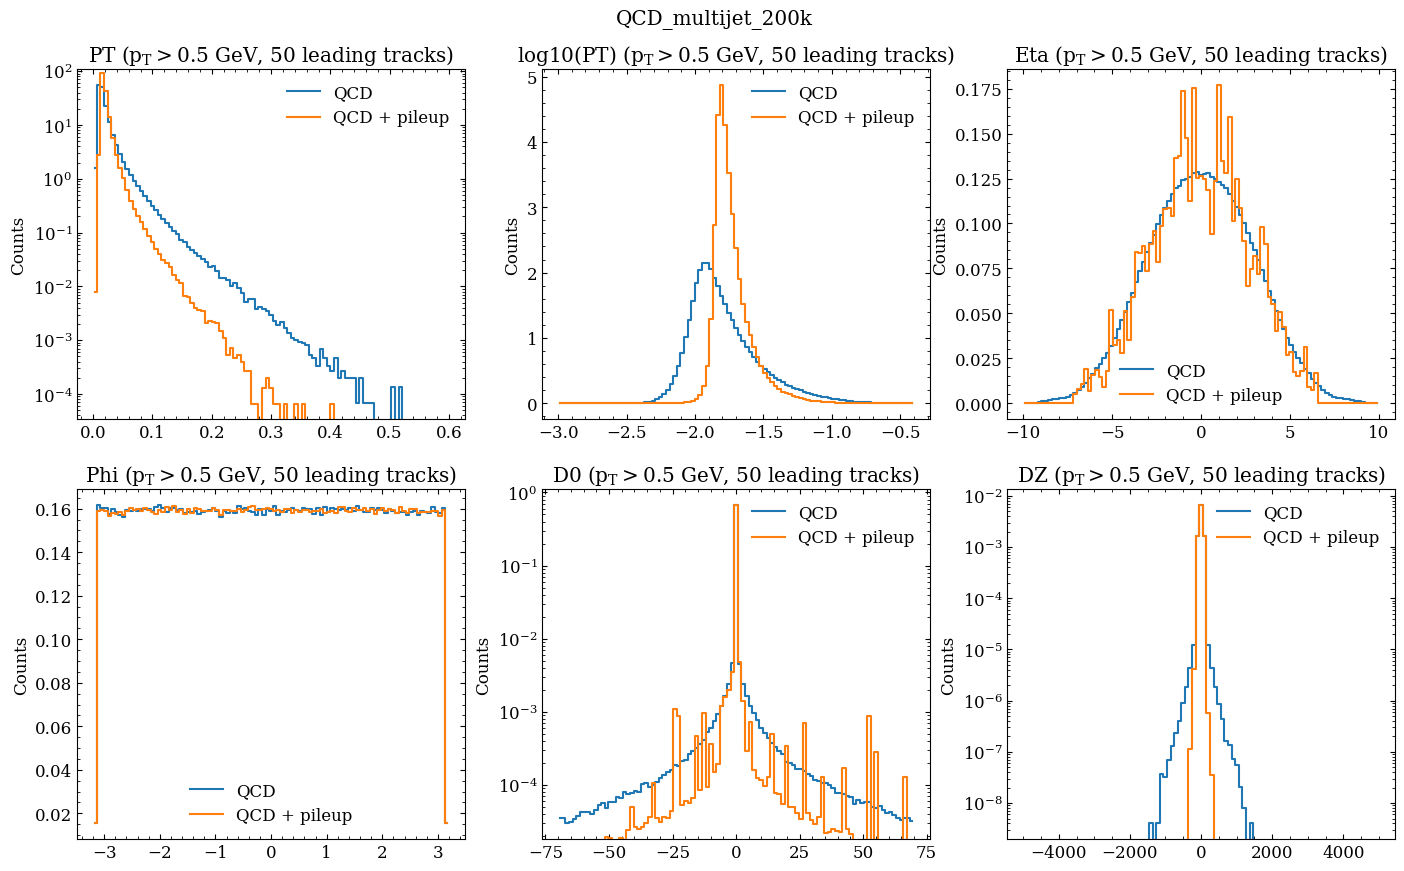

In [6]:
import os
data_qcd = uproot.open(qcd_file)["Delphes"]
data_qcd_pileup = uproot.open(qcd_file.replace('.root', '_pileup.root'))["Delphes"]

title = os.path.basename(qcd_file).replace('.root', '').replace('_events', '')

fig, axs = plt.subplots(2, 3, figsize=(17, 10))
for data, dset_label in zip([data_qcd, data_qcd_pileup],['QCD', 'QCD + pileup']):
    # Add title to plot
    labels = ["PT", "PT", "Eta", "Phi", "D0", "DZ"]
    log_scales = [True, False, False, False, True, True]

    pt = data["Track"]["Track.PT"].array(entry_stop=50000)
    ptcut = pt > 0.5
    argsort = ak.argsort(pt[ptcut], axis=1) 

    for i, (label, ax, log_scale) in enumerate(zip(labels, axs.ravel(), log_scales)):
        vals = data["Track"][f"Track.{label}"].array(entry_stop=50000)[ptcut][argsort][:,-50:]

        if label == "PT":
            vals = vals / ak.sum(vals, axis=1)
        if i == 1:
            vals = np.log10(vals)
            label = 'log10(PT)'

        vals = np.concatenate(vals).to_numpy()
        bins = {
            'PT': (0, 0.6),
            'log10(PT)': (-3,-0.4),
            'Eta': (-10,10),
            'Phi': (-3.2,3.2),
            'CtgTheta': (-4000,4000),
            'D0': (-70,70),
            'DZ': (-5000,5000)
        }
        bins = np.linspace(*bins[label], 100)
        
        counts,edges = np.histogram(vals, bins=bins,density=True)
        centers = (edges[:-1] + edges[1:]) / 2            
        ax.plot(centers, counts, label='normalized PT' if dset_label == 'PT' else dset_label, drawstyle='steps-mid')

        if log_scale:
            ax.set_yscale("log")
            ax.set_ylim(None, None)

        ax.set_ylabel("Counts")
        # ax.set_xlabel(label)
        ax.set_title(label+' ($p_T>0.5$ GeV, 50 leading tracks)')

        if dset_label=='QCD + pileup':
            ax.legend(frameon=False, fontsize=12)

plt.suptitle(title, y=0.94)
plt.savefig('plots/'+title.lower().replace(' ', '_')+'.png', dpi=100, bbox_inches='tight')
plt.show()

In [71]:
import h5py
import os
import awkward as ak
import numpy as np


def plot_input_parameters(qcd_pileup, qcd, llp_pileup, llp):
    data_qcd_pileup_f = h5py.File(qcd_pileup, "r")
    data_qcd_pileup_lens = data_qcd_pileup_f["lengths"]

    data_qcd_pileup = []
    curr_len = 0
    print('qcd pileup')
    for length in data_qcd_pileup_lens[:50000]:
        data_qcd_pileup.append(data_qcd_pileup_f["Track"][curr_len : curr_len + 50])
        curr_len += length
    data_qcd_pileup = np.concatenate(data_qcd_pileup)
    data_qcd_pileup_f.close()

    data_qcd_f = h5py.File(qcd, "r")
    data_qcd_lens = data_qcd_f["lengths"]
    print('qcd')
    data_qcd = []
    curr_len = 0
    for length in data_qcd_lens[:50000]:
        data_qcd.append(data_qcd_f["Track"][curr_len : curr_len + 50])
        curr_len += length
    data_qcd = np.concatenate(data_qcd)
    data_qcd_f.close()

    data_llp_pileup_f = h5py.File(llp_pileup, "r")
    print('llp pileup')
    data_llp_pileup_lens = data_llp_pileup_f["lengths"]

    data_llp_pileup = []
    curr_len = 0
    for length in data_llp_pileup_lens[:50000]:
        data_llp_pileup.append(data_llp_pileup_f["Track"][curr_len : curr_len + 50])
        curr_len += length
    data_llp_pileup = np.concatenate(data_llp_pileup)
    data_llp_pileup_f.close()

    data_llp_f = h5py.File(llp, "r")
    data_llp_lens = data_llp_f["lengths"]
    print('llp')

    data_llp = []
    curr_len = 0
    for length in data_llp_lens[:50000]:
        data_llp.append(data_llp_f["Track"][curr_len : curr_len + 50])
        curr_len += length
    data_llp = np.concatenate(data_llp)
    data_llp_f.close()

    title = os.path.basename(qcd).replace(".h5", "").replace("_events", "")

    fig, axs = plt.subplots(2, 3, figsize=(17, 10))
    for data, dset_label in zip(
        [data_qcd, data_qcd_pileup, data_llp, data_llp_pileup],
        ["QCD", "QCD + pileup", "LLP", "LLP + pileup"],
    ):
        # Add title to plot
        labels = ["PT", "PT", "Eta", "Phi", "D0", "DZ"]
        log_scales = [True, False, False, False, True, True]

        eta_mask = abs(data["Track.Eta"]) < 5

        for i, (label, ax, log_scale) in enumerate(
            zip(labels, axs.ravel(), log_scales)
        ):
            vals = data[f"Track.{label}"]
            if i == 1:
                vals = np.log10(vals)
                label = "log10(PT)"

            bins = {
                "PT": (0, 0.6),
                "log10(PT)": (-3, -0.5),
                "Eta": (-5, 5),
                "Phi": (-3.2, 3.2),
                "CtgTheta": (-4000, 4000),
                "D0": (-70, 70),
                "DZ": (-2000, 2000),
            }
            bins = np.linspace(*bins[label], 100)

            counts, edges = np.histogram(vals[eta_mask], bins=bins, density=True)
            centers = (edges[:-1] + edges[1:]) / 2
            ax.plot(
                centers,
                counts,
                label="normalized PT" if dset_label == "PT" else dset_label,
                drawstyle="steps-mid",
            )

            if log_scale:
                ax.set_yscale("log")
                ax.set_ylim(None, None)

            ax.set_ylabel("Counts")
            # ax.set_xlabel(label)
            ax.set_title(label + " ($p_T>0.5$ GeV, 50 leading tracks)")

            if dset_label == "LLP + pileup":
                ax.legend(frameon=False, fontsize=12)

    plt.suptitle(title, y=0.94)
    plt.savefig(
        "plots/" + title.lower().replace(" ", "_") + ".png",
        dpi=100,
        bbox_inches="tight",
    )
    plt.show()

In [74]:
qcd_pileup = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/pileup_50tracks/QCD_multijet_events_200k_pileup.h5"
qcd = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/QCD_multijet_events_200k.h5"
llp = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/100GeV_n3_events_100k_1mm.h5"
llp_pileup = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/pileup_50tracks/100GeV_n3_events_100k_1mm_pileup.h5"

qcd pileup
qcd
llp pileup
llp


/tmp/ipykernel_1428124/2481445518.py:73: RuntimeWarning: invalid value encountered in log10
  vals = np.log10(vals)


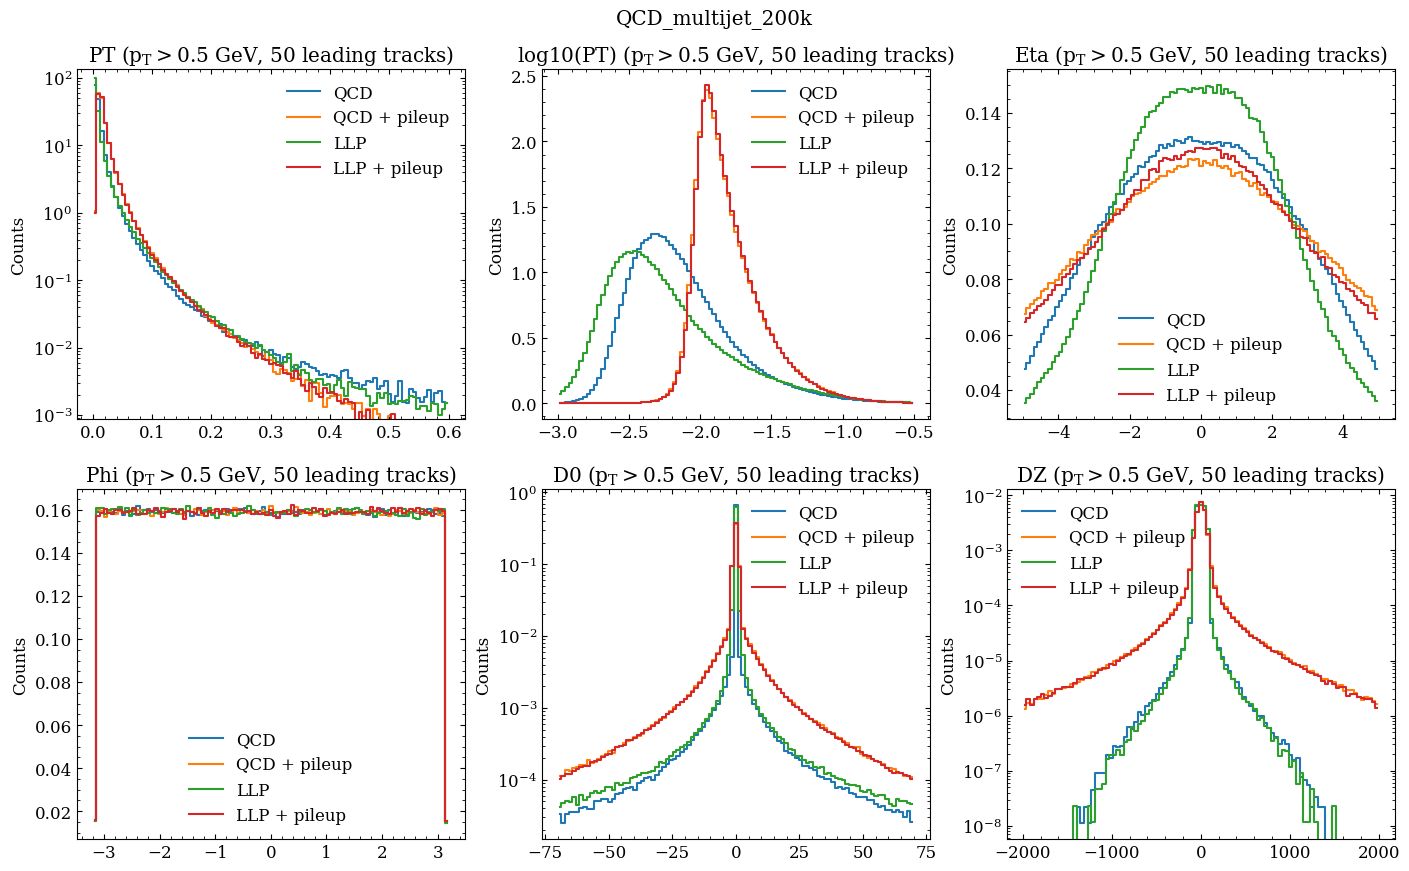

In [75]:
plot_input_parameters(qcd_pileup, qcd, llp_pileup, llp)

In [73]:
qcd_pileup = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/old_h5/QCD_multijet_events_200k_pileup.h5"
qcd = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/old_h5/QCD_multijet_events_200k.h5"
llp = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/old_h5/100GeV_n3_events_100k_1mm.h5"
llp_pileup = "/sdf/home/y/youngsam/data/atlas/qcd_llp_datasets/old_h5/100GeV_n3_events_100k_1mm_pileup.h5"

qcd pileup
qcd
llp pileup
llp


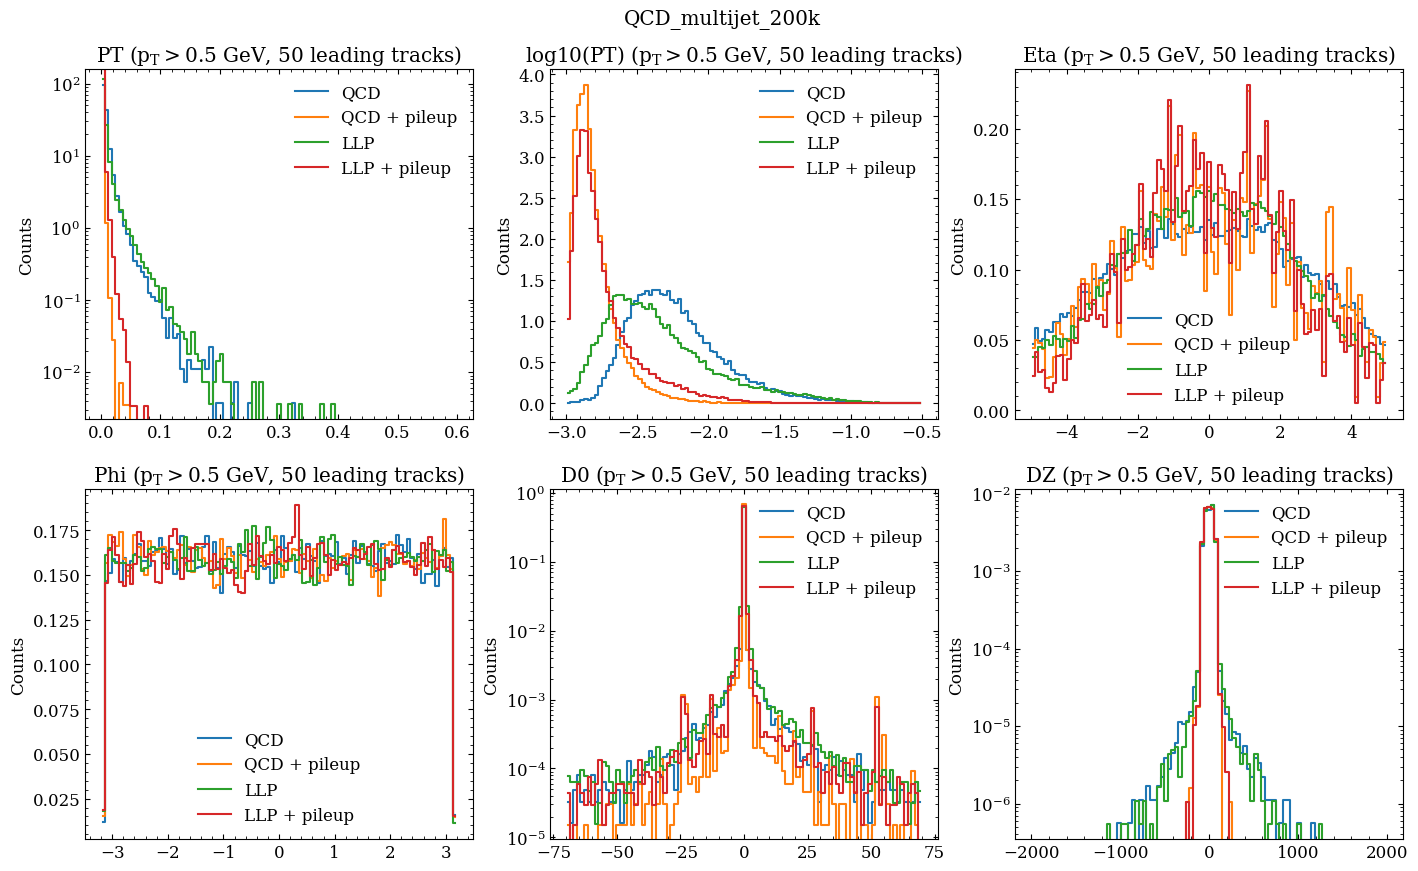

In [70]:
plot_input_parameters(qcd_pileup, qcd, llp_pileup, llp)